# Assignment 3: Heartbeat Sounds - Kaggle Competition

**Team Members**

> 1. Sohaila Hazem - 6388
2. Areej Salahuddin - 6389
3. Manar Abdelkader - 6485

In [1]:
from google.colab import drive
import os
import glob
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
from scipy.io import wavfile
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import compute_class_weight
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,LSTM, Bidirectional
from keras.layers import Convolution2D, Conv2D, Conv1D, MaxPooling2D, GlobalAveragePooling2D, MaxPooling1D, GlobalAveragePooling1D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc
from itertools import cycle

In [2]:
drive.mount('/gdrive', force_remount = True)
!ln -s "/gdrive/MyDrive/HeartBeats/set_a" "/content/set_a"
!ln -s "/gdrive/MyDrive/HeartBeats/set_b" "/content/set_b"
!ln -s "/gdrive/MyDrive/HeartBeats/set_a_timing.csv" "/content/set_a_timing.csv"
!ln -s "/gdrive/MyDrive/HeartBeats/set_a.csv" "/content/set_a.csv"
!ln -s "/gdrive/MyDrive/HeartBeats/set_b.csv" "/content/set_b.csv"
setaa_path = "/content/set_a.csv"
setbb_path = "/content/set_b.csv"
seta_path = "/content/set_a"
setb_path = "/content/set_b"

Mounted at /gdrive


# Data Exploratory Analysis

***The dataset is primarily audio-based containg the heartbeat sounds stored as WAV files that record either normal or abnormal heartbeats.***

**Dataset A Timings:** 
 - Contains audio segmentation data, giving time locations of the S1 (lub) and S2 (dub) sounds within the Normal audio files of set A.


**Dataset A:** 
- Collected from the general public via the iStethoscope Pro iPhone app.

- Contains 124 labelled sound clips from four classes: *normal, murmur, extra heart sound, and arfifact.*

- Contains 52 unlabeled sound clips.

**Dataset B:** 

- Collected from a clinical trial in hospitals using the digital stethoscope DigiScope.
- Contains 461 labelled sound clips from three classes: normal, murmur, extrasystole.*

- Contains 71 unlabeled sound clips.







#### First File: *set_a_timing.csv*
 
    contains gold-standard timing information for the "normal" recordings from Set A.

In [3]:
set_a_timing_df = pd.read_csv("set_a_timing.csv")
set_a_timing_df.head(-1)

fname  cycle sound  location
0    set_a/normal__201102081321.wav      1    S1     10021
1    set_a/normal__201102081321.wav      1    S2     20759
2    set_a/normal__201102081321.wav      2    S1     35075
3    set_a/normal__201102081321.wav      2    S2     47244
4    set_a/normal__201102081321.wav      3    S1     62992
..                              ...    ...   ...       ...
384  set_a/normal__201108011118.wav     10    S1    272527
385  set_a/normal__201108011118.wav     10    S2    284673
386  set_a/normal__201108011118.wav     11    S1    300863
387  set_a/normal__201108011118.wav     11    S2    314279
388  set_a/normal__201108011118.wav     12    S1    330980

[389 rows x 4 columns]

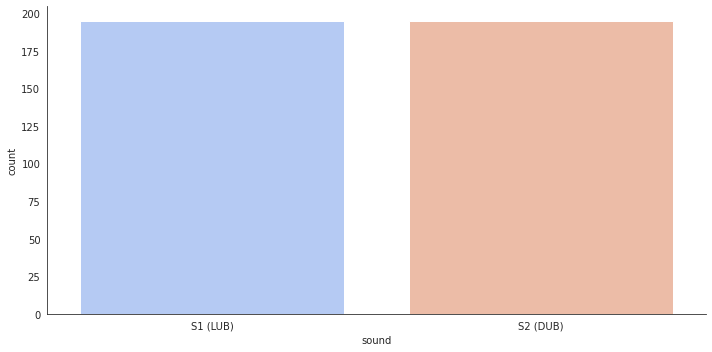

In [4]:
with sns.axes_style('white'):
    g = sns.catplot(data=set_a_timing_df, x="sound", aspect=2,
                       kind="count", palette='coolwarm')
    g.set_xticklabels(["S1 (LUB)","S2 (DUB)"])

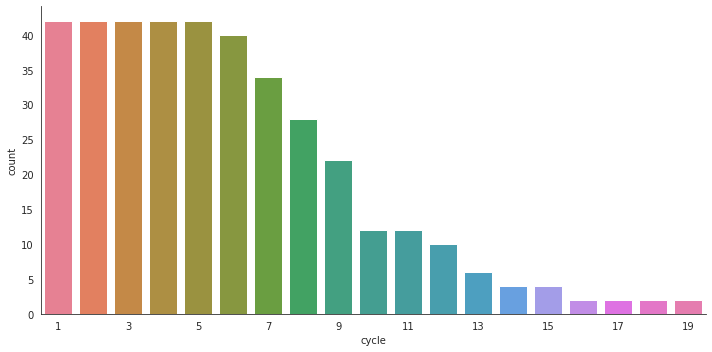

In [5]:
with sns.axes_style('white'):
    g = sns.catplot(data=set_a_timing_df, x="cycle", aspect=2,
                       kind="count", palette='husl')
    g.set_xticklabels(step=2)

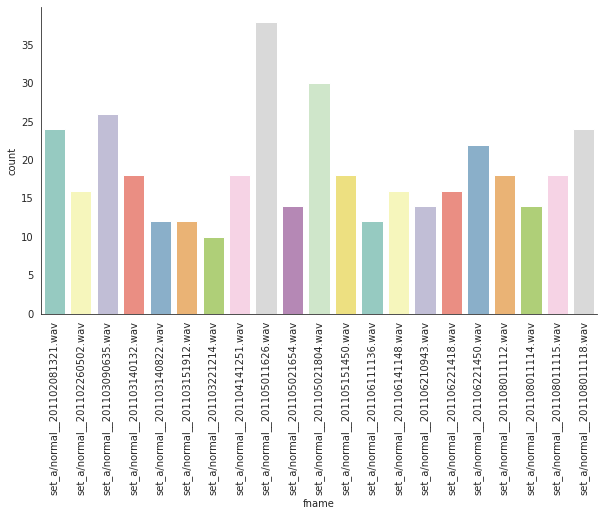

In [6]:
with sns.axes_style('white'):
    g = sns.catplot(data=set_a_timing_df, x="fname", aspect=2,
                       kind="count", palette='Set3')
    g.set_xticklabels(set_a_timing_df.fname.unique())
    g.set_xticklabels(rotation=90)

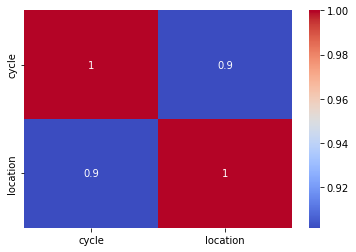

In [7]:
dataplot = sns.heatmap(set_a_timing_df.corr(), cmap="coolwarm", annot=True)
plt.show()

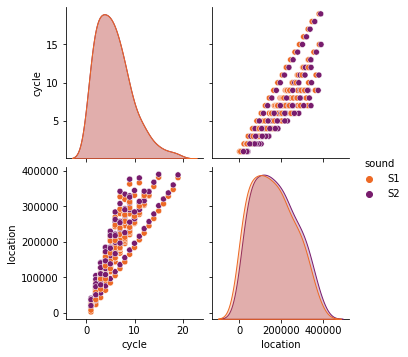

In [8]:
sns.pairplot(set_a_timing_df, diag_kind="kde", hue="sound", palette="inferno_r")
plt.show()

#### Second File: *set_a.csv*
 
*Labels and metadata for heart beats collected from the general public via the iStethoscope Pro iPhone app.*

In [9]:
set_a_df = pd.read_csv("set_a.csv")
set_a_df.head(-1)

dataset                             fname     label  sublabel
0         a  set_a/artifact__201012172012.wav  artifact       NaN
1         a  set_a/artifact__201105040918.wav  artifact       NaN
2         a  set_a/artifact__201105041959.wav  artifact       NaN
3         a  set_a/artifact__201105051017.wav  artifact       NaN
4         a  set_a/artifact__201105060108.wav  artifact       NaN
..      ...                               ...       ...       ...
170       a          set_a/__201108222234.wav       NaN       NaN
171       a          set_a/__201108222241.wav       NaN       NaN
172       a          set_a/__201108222244.wav       NaN       NaN
173       a          set_a/__201108222247.wav       NaN       NaN
174       a          set_a/__201108222254.wav       NaN       NaN

[175 rows x 4 columns]

In [10]:
set_a_df["label"].value_counts()

artifact    40
murmur      34
normal      31
extrahls    19
Name: label, dtype: int64

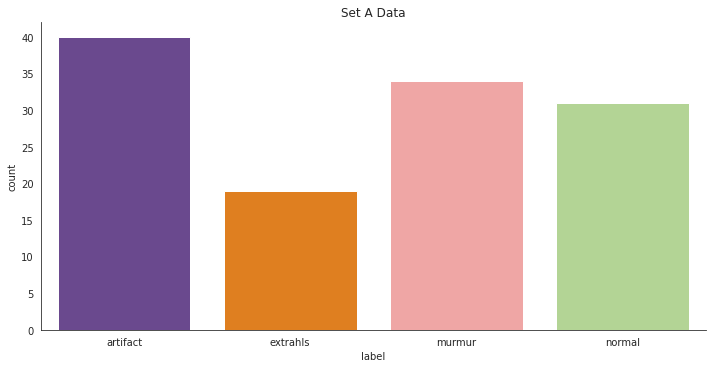

In [11]:
with sns.axes_style('white'):
    g = sns.catplot(data=set_a_df, x="label", aspect=2,
                       kind="count", palette='Paired_r')
    plt.title("Set A Data")

Text(0.5, 1.0, 'Set A Data')

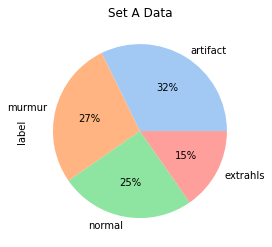

In [12]:
set_a_df['label'].value_counts(normalize=True).plot(kind='pie',colors = sns.color_palette('pastel')[0:5], autopct='%.0f%%')
plt.title("Set A Data")

#### Third File: *set_b.csv*
 
    Labels and metadata for heart beats collected from a clinical trial in hospitals using a digital stethoscope DigiScope.
     

In [12]:
set_b_df = pd.read_csv("set_b.csv")
set_b_df.head(-1)

dataset                                              fname       label  \
0         b  set_b/Btraining_extrastole_127_1306764300147_C...  extrastole   
1         b  set_b/Btraining_extrastole_128_1306344005749_A...  extrastole   
2         b  set_b/Btraining_extrastole_130_1306347376079_D...  extrastole   
3         b  set_b/Btraining_extrastole_134_1306428161797_C...  extrastole   
4         b  set_b/Btraining_extrastole_138_1306762146980_B...  extrastole   
..      ...                                                ...         ...   
650       b  set_b/Btraining_normal_Btraining_noisynormal_2...      normal   
651       b  set_b/Btraining_normal_Btraining_noisynormal_2...      normal   
652       b  set_b/Btraining_normal_Btraining_noisynormal_2...      normal   
653       b  set_b/Btraining_normal_Btraining_noisynormal_2...      normal   
654       b  set_b/Btraining_normal_Btraining_noisynormal_2...      normal   

        sublabel  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
..           ...  
650  noisynormal  
651  noisynormal  
652  noisynormal  
653  noisynormal  
654  noisynormal  

[655 rows x 4 columns]

In [13]:
set_b_df["label"].value_counts()

normal        320
murmur         95
extrastole     46
Name: label, dtype: int64

In [14]:
set_b_df["sublabel"].value_counts()

noisynormal    120
noisymurmur     29
Name: sublabel, dtype: int64

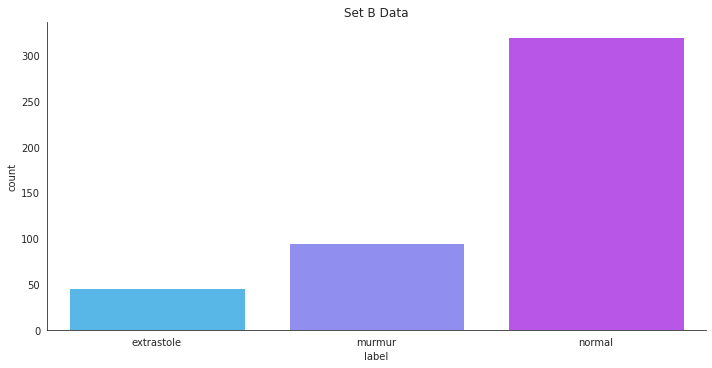

In [15]:
with sns.axes_style('white'):
    g = sns.catplot(data=set_b_df, x="label", aspect=2,
                       kind="count", palette='cool')
    plt.title("Set B Data")

Text(0.5, 1.0, 'Set B Data')

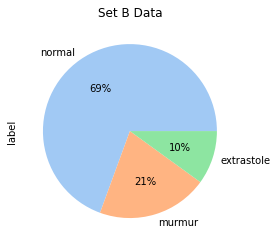

In [16]:
set_b_df['label'].value_counts(normalize=True).plot(kind='pie',colors = sns.color_palette('pastel')[0:5], autopct='%.0f%%')
plt.title("Set B Data")

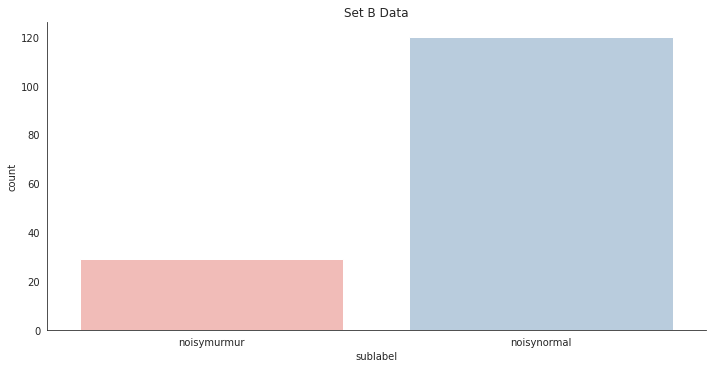

In [17]:
with sns.axes_style('white'):
    g = sns.catplot(data=set_b_df, x="sublabel", aspect=2,
                       kind="count", palette="Pastel1")
    plt.title("Set B Data")

Text(0.5, 1.0, 'Set B Data')

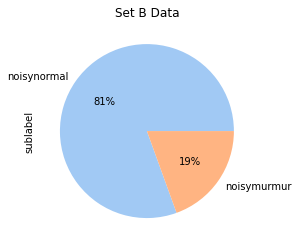

In [18]:
set_b_df['sublabel'].value_counts(normalize=True).plot(kind='pie',colors = sns.color_palette('pastel')[0:5], autopct='%.0f%%')
plt.title("Set B Data")

#### **Concatenating both sets A & B together.**




In [19]:
ab = [set_a_df, set_b_df]
set_ab_df = pd.concat(ab)
set_ab_df = set_ab_df.reset_index(drop=False)
set_ab_df.head(-1)

index dataset                                              fname  \
0        0       a                   set_a/artifact__201012172012.wav   
1        1       a                   set_a/artifact__201105040918.wav   
2        2       a                   set_a/artifact__201105041959.wav   
3        3       a                   set_a/artifact__201105051017.wav   
4        4       a                   set_a/artifact__201105060108.wav   
..     ...     ...                                                ...   
826    650       b  set_b/Btraining_normal_Btraining_noisynormal_2...   
827    651       b  set_b/Btraining_normal_Btraining_noisynormal_2...   
828    652       b  set_b/Btraining_normal_Btraining_noisynormal_2...   
829    653       b  set_b/Btraining_normal_Btraining_noisynormal_2...   
830    654       b  set_b/Btraining_normal_Btraining_noisynormal_2...   

        label     sublabel  
0    artifact          NaN  
1    artifact          NaN  
2    artifact          NaN  
3    artifact          NaN  
4    artifact          NaN  
..        ...          ...  
826    normal  noisynormal  
827    normal  noisynormal  
828    normal  noisynormal  
829    normal  noisynormal  
830    normal  noisynormal  

[831 rows x 5 columns]

In [20]:
set_ab_df.describe()

index
count  832.000000
mean   276.730769
std    196.149418
min      0.000000
25%    103.750000
50%    239.500000
75%    447.250000
max    655.000000

In [21]:
set_ab_df["label"].value_counts()

normal        351
murmur        129
extrastole     46
artifact       40
extrahls       19
Name: label, dtype: int64

Text(0.5, 1.0, 'Set AB Data')

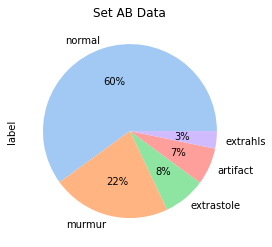

In [22]:
set_ab_df['label'].value_counts(normalize=True).plot(kind='pie',colors = sns.color_palette('pastel')[0:5], autopct='%.0f%%')
plt.title("Set AB Data")

In [23]:
set_ab_df["sublabel"].value_counts()

noisynormal    120
noisymurmur     29
Name: sublabel, dtype: int64

Text(0.5, 1.0, 'Set AB Data')

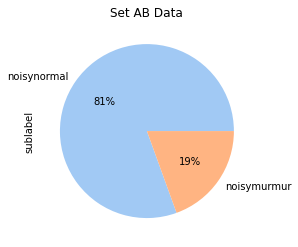

In [24]:
set_ab_df['sublabel'].value_counts(normalize=True).plot(kind='pie',colors = sns.color_palette('pastel')[0:5], autopct='%.0f%%')
plt.title("Set AB Data")

> Keeping in mind that there are **unlabeled** instances in both sets **A** and **B**.

In [25]:
labels = set_ab_df.label.unique()
print(f"Number of classes in both sets A & B = {len(labels)}, which are:\n{labels}")

Number of classes in both sets A & B = 6, which are:
['artifact' 'extrahls' 'murmur' 'normal' nan 'extrastole']


> Sets **a** and **b** distribution:

In [26]:
print('Min samples per category = ', min(set_ab_df.label.value_counts()))
print('Max samples per category = ', max(set_ab_df.label.value_counts()))

Min samples per category =  19
Max samples per category =  351


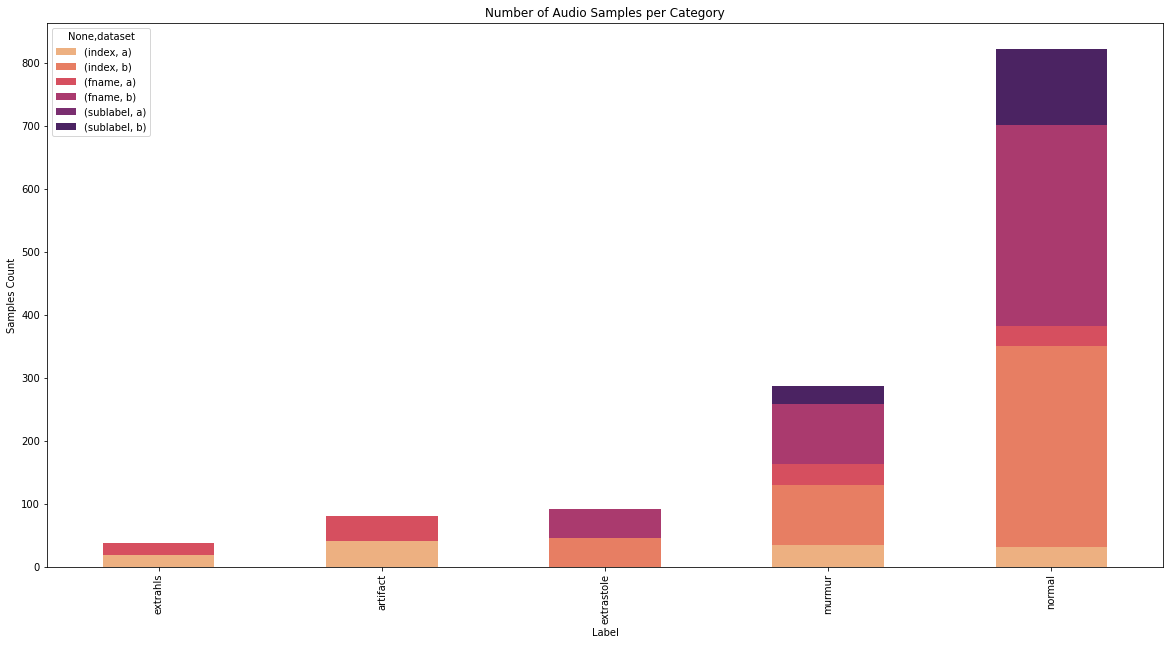

In [27]:
category_group = set_ab_df.groupby(['label','dataset']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(20,10), cmap="flare")

plot.set_xlabel("Label")
plot.set_ylabel("Samples Count");

### Audio Files Analysis

In [28]:
DF = []
files = []

for root, dirnames, filenames in os.walk(seta_path):
  for file_name in filenames:
    files.append(os.path.join(root, file_name))

for root, dirnames, filenames in os.walk(setb_path):
  for file_name in filenames:
    files.append(os.path.join(root, file_name))

for filename in files:
  label = os.path.basename(filename).split("_")[0]
  duration = librosa.get_duration(filename=filename)
  DF.append({"filename": filename, "label": label, "duration (seconds)": duration})
  
dataframe = pd.DataFrame(DF)

cond_counts = dataframe['label'].value_counts()
min_duration = dataframe.groupby('label')['duration (seconds)'].min()
max_duration = dataframe.groupby('label')['duration (seconds)'].max()
mean_duration = dataframe.groupby('label')['duration (seconds)'].max()
total_duration = dataframe.groupby('label')['duration (seconds)'].sum()

audio_duration_dict = {'min duration' : min_duration, 'max duration': max_duration, 'mean duration':mean_duration, 
                       'total duration':total_duration, 'number of samples': cond_counts}
audio_duration_summary = pd.DataFrame(audio_duration_dict)
display('Auditory Duration Summary in seconds')
pd.DataFrame(audio_duration_dict)

'Auditory Duration Summary in seconds'

min duration  max duration  mean duration  total duration  \
Aunlabelledtest      1.754875       9.00000        9.00000      422.725102   
Bunlabelledtest      1.027500      24.44875       24.44875     1309.889500   
artifact             9.000000       9.00000        9.00000      360.000000   
extrahls             0.936372       9.00000        9.00000      130.572494   
extrastole           1.874500      13.38075       13.38075      269.470000   
murmur               0.856750      24.16000       24.16000     1002.851552   
normal               0.763250      27.86700       27.86700     2217.682312   

                 number of samples  
Aunlabelledtest                 52  
Bunlabelledtest                195  
artifact                        40  
extrahls                        19  
extrastole                      46  
murmur                         129  
normal                         351

**The above analysis indicates that there is class inbalance in both the number of samples per label and the mean duration per label. This class inbalance will be problematic later when we train the model which lead us to compute class weights later.**

## Sample by Category: 
>We can visualize the audio signals of the recordings using oscillograms and spectrograms.

***Oscillogram:***

*    It is a measure of a sound wave's Amplitude vs Time.

***Melspectrogram:***

*    It represents an acoustic time-frequency representation of a sound.
*    It is basically a spectrogram with the Mel
Scale as its y-axis.

> This Mel Scale is constructed such that sounds are
equal distance from each other on the Mel Scale.

***MFCC (Mel Frequency Cepstral Components):*** 


*   It is representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.
*  MFCCs are
commonly used as a feature type in automatic speech recognition.

> We chose to use this to perform this transformation, as
FCCs capture features from audio data that more closely resembles
how human beings perceive loudness and pitch. 

In [29]:
def plot_mfcc_spect(filewave):
   y, sr = librosa.load(filewave)
   S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
   log_S = librosa.amplitude_to_db(S)
   plt.figure(figsize=(12,4))
   librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
   plt.title('mel power spectrogram')
   plt.colorbar(format='%+02.0f dB')
   plt.tight_layout()
   mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
   delta_mfcc  = librosa.feature.delta(mfcc)
   plt.figure(figsize=(12, 6))
   plt.subplot(3,1,1)
   librosa.display.specshow(mfcc)
   plt.ylabel('MFCC')
   plt.colorbar()
   plt.tight_layout()

### *Normal*

In [30]:
normal_example = seta_path + "/normal__201102201230.wav"
ipd.Audio(normal_example) 

Sampling rate =  44100
Total samples =  396900
[10 11  5 ...  1  3  3]


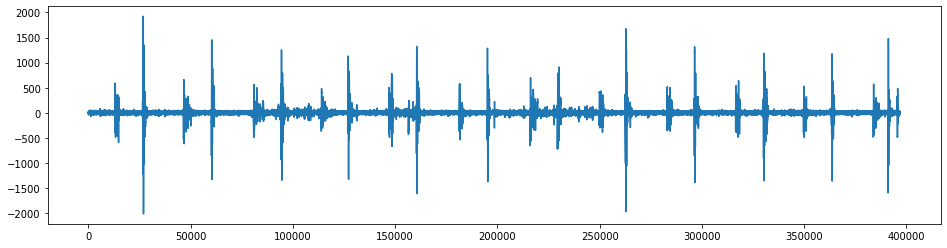

In [31]:
rate, data = wavfile.read(normal_example)
print("Sampling rate = ", rate)
print("Total samples = ", len(data))
print(data)
plt.figure(figsize=(16, 4))
plt.plot(data, '-', )
plt.show()

duration: 5.0
(110250,) 22050


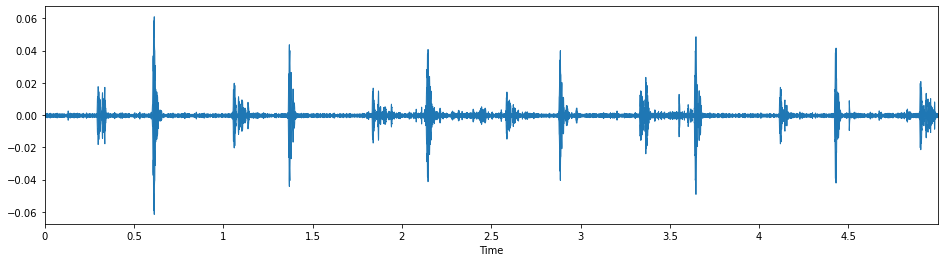

In [32]:
y, sr = librosa.load(normal_example, duration = 5)   #default sampling rate is 22 HZ
dur=librosa.get_duration(y)
print ("duration:", dur)
print(y.shape, sr)
# librosa plot
plt.figure(figsize=(16, 4))
librosa.display.waveplot(y, sr=sr)
plt.show()

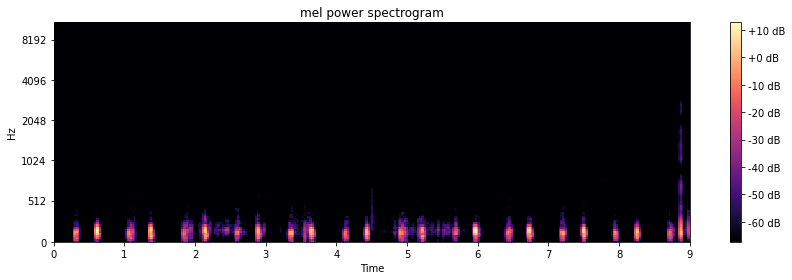

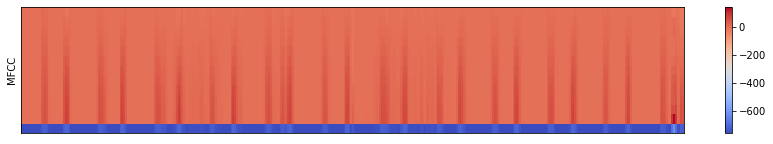

In [33]:
plot_mfcc_spect(normal_example)

### *Murmur*

In [34]:
murmur_example = seta_path + "/murmur__201108222255.wav"
ipd.Audio(murmur_example) 

Sampling rate =  44100
Total samples =  349958
[180 192 200 ... 108 115   0]


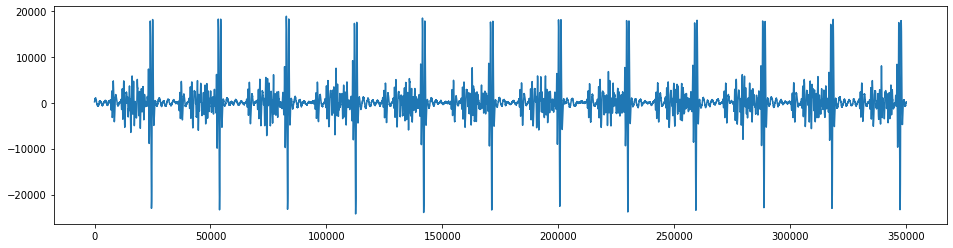

In [35]:
rate, data = wavfile.read(murmur_example)
print("Sampling rate = ", rate)
print("Total samples = ", len(data))
print(data)
plt.figure(figsize=(16, 4))
plt.plot(data, '-', )
plt.show()

duration: 5.0
(110250,) 22050


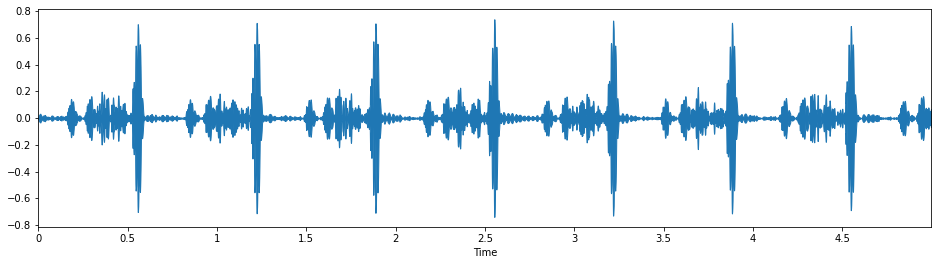

In [36]:
y, sr = librosa.load(murmur_example, duration = 5)   #default sampling rate is 22 HZ
dur = librosa.get_duration(y)
print ("duration:", dur)
print(y.shape, sr)
# librosa plot
plt.figure(figsize=(16, 4))
librosa.display.waveplot(y, sr=sr)
plt.show()

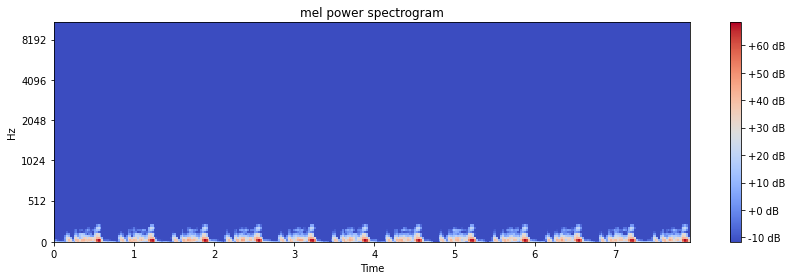

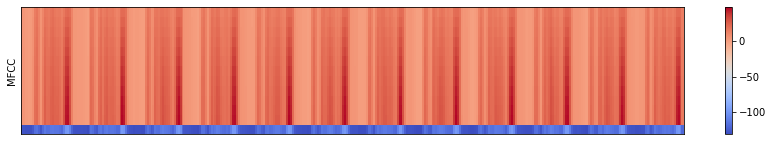

In [37]:
plot_mfcc_spect(murmur_example)

### *Extrasystole*

In [38]:
extrasystole_example = setb_path + "/extrastole__128_1306344005749_A.wav"
ipd.Audio(extrasystole_example) 

Sampling rate =  4000
Total samples =  36946
[ 747  485  363 ... -657 -679 -693]


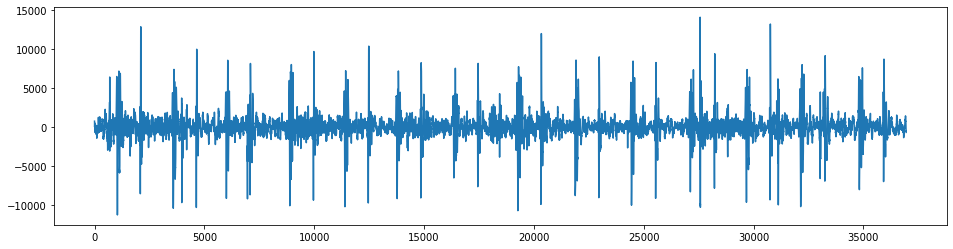

In [39]:
rate, data = wavfile.read(extrasystole_example)
print("Sampling rate = ", rate)
print("Total samples = ", len(data))
print(data)
plt.figure(figsize=(16, 4))
plt.plot(data, '-', )
plt.show()

duration: 5.0
(110250,) 22050


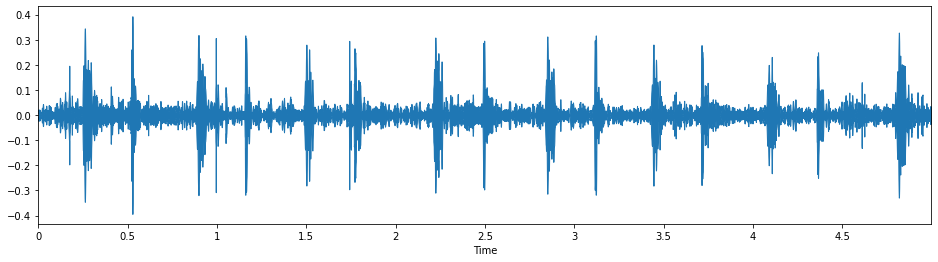

In [40]:
y, sr = librosa.load(extrasystole_example, duration = 5)   #default sampling rate is 22 HZ
dur=librosa.get_duration(y)
print ("duration:", dur)
print(y.shape, sr)
# librosa plot
plt.figure(figsize=(16, 4))
librosa.display.waveplot(y, sr=sr)
plt.show()

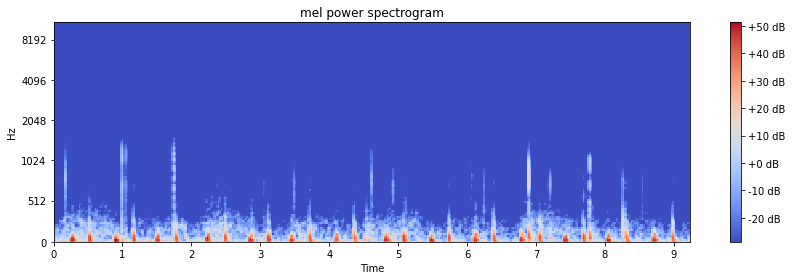

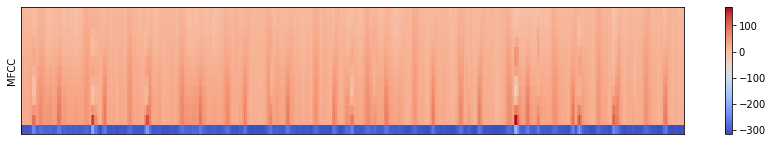

In [41]:
plot_mfcc_spect(extrasystole_example)

### *Artifact*

In [42]:
artifcat_example = seta_path + "/artifact__201012172012.wav"
ipd.Audio(artifcat_example) 

Sampling rate =  44100
Total samples =  396900
[ 1 -3 -1 ...  0  1  0]


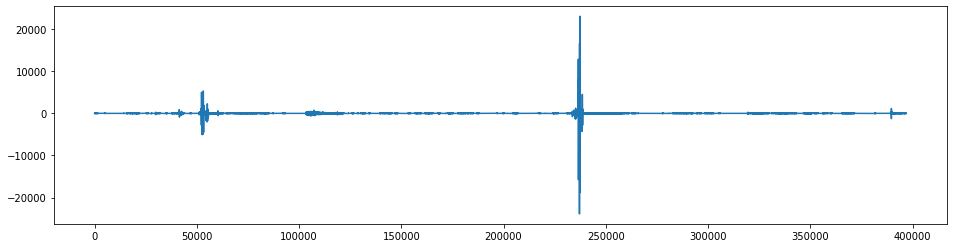

In [43]:
rate, data = wavfile.read(artifcat_example)
print("Sampling rate = ", rate)
print("Total samples = ", len(data))
print(data)
plt.figure(figsize=(16, 4))
plt.plot(data, '-', )
plt.show()

duration: 5.0
(110250,) 22050


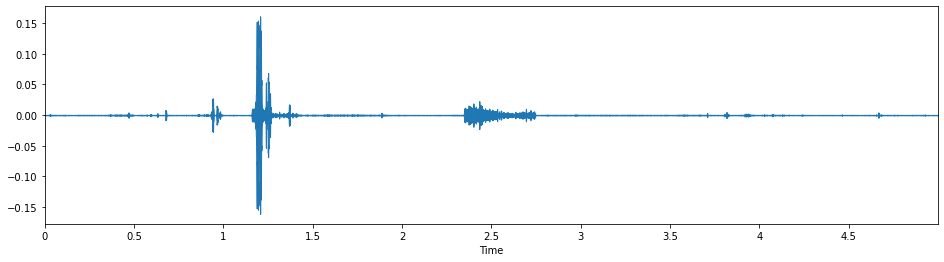

In [44]:
y, sr = librosa.load(artifcat_example, duration = 5)   #default sampling rate is 22 HZ
dur=librosa.get_duration(y)
print ("duration:", dur)
print(y.shape, sr)
# librosa plot
plt.figure(figsize=(16, 4))
librosa.display.waveplot(y, sr=sr)
plt.show()


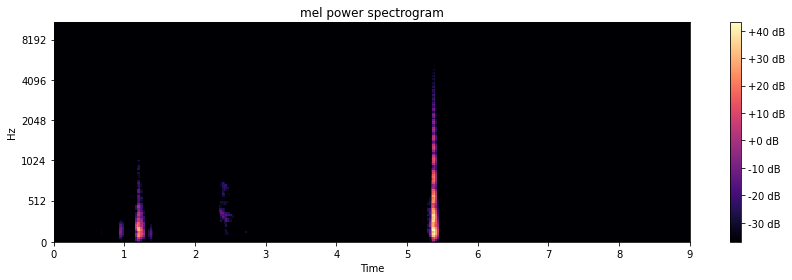

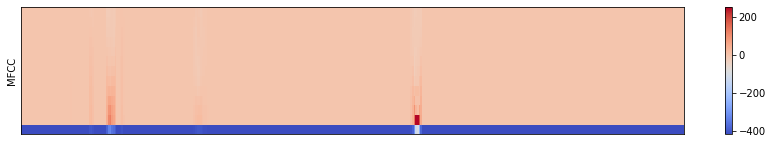

In [45]:
plot_mfcc_spect(artifcat_example)

### *Extra Heart Sound*

In [46]:
extrahls_example = seta_path + "/extrahls__201101160808.wav"
ipd.Audio(extrahls_example)

Sampling rate =  44100
Total samples =  271970
[475 462 442 ...   5  -7 -16]


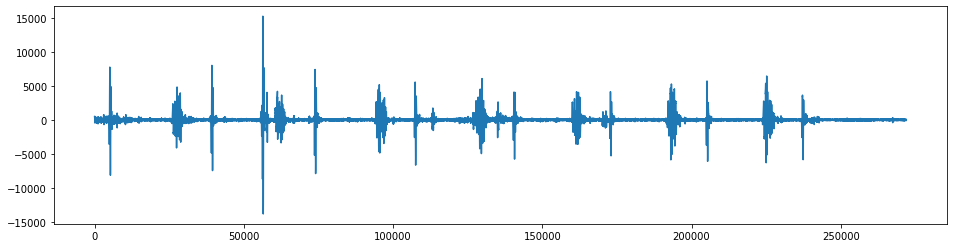

In [47]:
rate, data = wavfile.read(extrahls_example)
print("Sampling rate = ", rate)
print("Total samples = ", len(data))
print(data)
plt.figure(figsize=(16, 4))
plt.plot(data, '-', )
plt.show()

duration: 5.0
(110250,) 22050


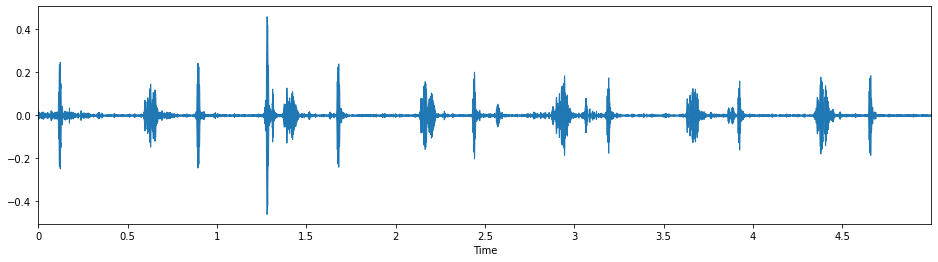

In [48]:
y, sr = librosa.load(extrahls_example, duration = 5)   #default sampling rate is 22 HZ
dur=librosa.get_duration(y)
print ("duration:", dur)
print(y.shape, sr)
# librosa plot
plt.figure(figsize=(16, 4))
librosa.display.waveplot(y, sr=sr)
plt.show()

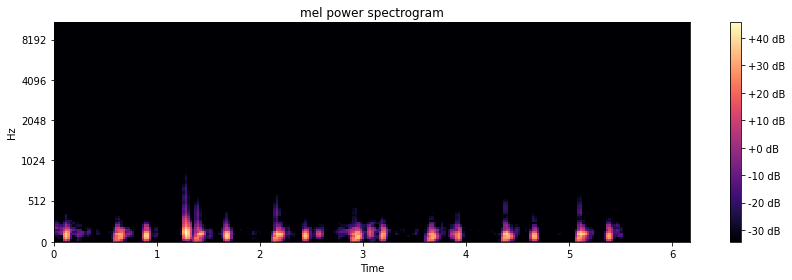

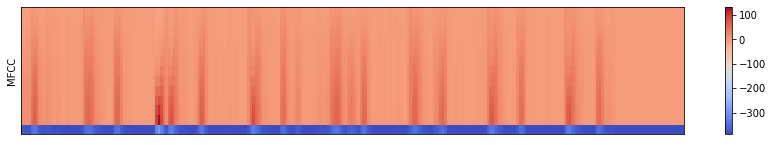

In [49]:
plot_mfcc_spect(extrahls_example)



---





# Second Task: Classification

### Data Preprocessing:

**For Preprocessing:**
1. Unlabelled data and artifact-labelled data will be excluded.

1. We are going to exclude audio files that have a duration less than 3 seconds as they do not contain enough datapoints to accurately classify the heartbeats.

3. We sliced the heartbeat sounds into fixed-length segments of length 3 seconds to increase the size of the dataset by slicing large files into multiple smaller files while still retaining the original labels.

In [52]:
D = []
files = []

for root, dirnames, filenames in os.walk(seta_path):
  for file_name in filenames:
    files.append(os.path.join(root, file_name))

for root, dirnames, filenames in os.walk(setb_path):
  for file_name in filenames:
    files.append(os.path.join(root, file_name))

for filename in files:
  label = os.path.basename(filename).split("_")[0]
  duration = librosa.get_duration(filename=filename)
  # dividing the audio into partitions of 3 seconds
  # ignoring audio files with duration < 3 seconds
  if duration >= 3:
    no_of_iterations = int((duration - 3)/2) + 1
    if label not in ["Aunlabelledtest", "Bunlabelledtest", "artifact"]:
      for i in range(no_of_iterations):
        offset = 2*i + 1
        D.append({"filename": filename, "label": label, "offset": offset})
  
df = pd.DataFrame(D)
df.head(-1)

filename     label  offset
0             /content/set_a/extrahls__201103170134.wav  extrahls       1
1             /content/set_a/extrahls__201103170134.wav  extrahls       3
2             /content/set_a/extrahls__201103170134.wav  extrahls       5
3             /content/set_a/extrahls__201101152255.wav  extrahls       1
4             /content/set_a/extrahls__201101152255.wav  extrahls       3
...                                                 ...       ...     ...
1275  /content/set_b/normal_noisynormal_146_13067787...    normal       9
1276  /content/set_b/normal_noisynormal_146_13067787...    normal      11
1277  /content/set_b/normal_noisynormal_146_13067787...    normal      13
1278  /content/set_b/normal_noisynormal_146_13067787...    normal      15
1279  /content/set_b/normal_noisynormal_146_13067787...    normal      17

[1280 rows x 3 columns]

In [53]:
# shuffling for randomness
df = shuffle(df, random_state=42)

>Visuilalising clean data that will be used 

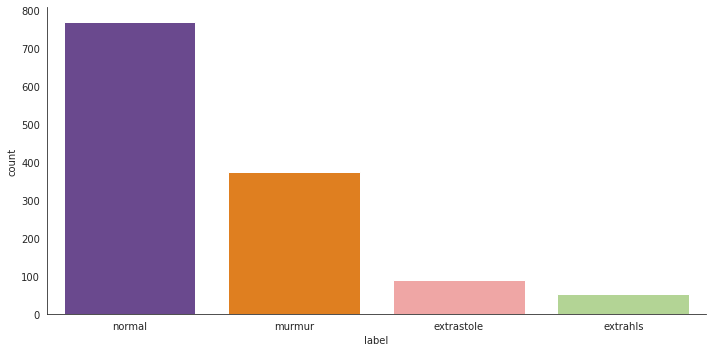

In [54]:
with sns.axes_style('white'):
    g = sns.catplot(data=df, x="label", aspect=2,
                       kind="count", palette='Paired_r')

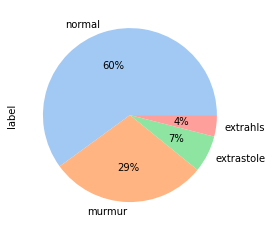

In [55]:
df['label'].value_counts(normalize=True).plot(kind='pie',colors = sns.color_palette('pastel')[0:5], autopct='%.0f%%')

### Helper Functions: 

#### Feature Extraction:



***MFCCs are commonly derived as follows:***
1.   Take the Fourier transform of (a windowed excerpt of) a signal.
2.   Map the powers of the spectrum obtained above onto the mel scale, using triangular overlapping windows or alternatively, cosine overlapping windows.
3. Take the logs of the powers at each of the mel frequencies.
4. Take the discrete cosine transform of the list of mel log powers, as if it were a signal.
5. The MFCCs are the amplitudes of the resulting spectrum.





> Extracting Features for MLP:

In [56]:
def extracting_features(filename, offset):
  # loading the audio file
  Y, sample_rate = librosa.load(filename, offset=offset, duration=3, res_type='kaiser_fast')
  # extracting features from the audio
  mfcc = np.mean(librosa.feature.mfcc(y=Y, sr=sample_rate, n_mfcc=40).T, axis=0)
  feature = np.array(mfcc).reshape([-1,1])
  return mfcc

In [57]:
def extract_features_helper(data):
  X = []
  for i in tqdm(range(len(data))):
      filename = data['filename'].iloc[i]
      offset = data.offset.iloc[i]
      X.append(np.array(extracting_features(filename, offset)))
  return X



> Extracting Features for CNN:




In [58]:
from tqdm import tqdm
def extract_features(data):
  X = []
  for i in tqdm(range(len(data))):
    filename = data['filename'].iloc[i]
    offset = data.offset.iloc[i]
    try:
      y, sr = librosa.load(filename, offset=offset, duration=3, res_type='kaiser_fast')  
      mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
      pad_width = 130 - mfccs.shape[1]
      mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
      X.append(mfccs)  
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 

  return X

#### Plotting the Training and Validation Accuracies and losses :

In [59]:
def plotfn(history):
    # Loss Curves
    plt.figure(figsize=[14,10])
    plt.subplot(211)
    plt.plot(history.history['loss'],'#d62728',linewidth=3.0)
    plt.plot(history.history['val_loss'],'#1f77b4',linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves',fontsize=16)
 
    # Accuracy Curves
    plt.figure(figsize=[14,10])
    plt.subplot(212)
    plt.plot(history.history['accuracy'],'#d62728',linewidth=3.0)
    plt.plot(history.history['val_accuracy'],'#1f77b4',linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves',fontsize=16)

#### Evaluation (Accuracy and Loss):

In [60]:
def evaluation_train_val(model,x,y,x_va,y_va,results,index):
  score1 = model.evaluate(x, y, verbose=0)
  print("Training Accuracy: ", score1[1])
  print("Training Loss: ", score1[0])
  score2 = model.evaluate(x_va, y_va, verbose=0)
  print("Validation Accuracy: ", score2[1])
  print("Validation Loss: ", score2[0])
  results.loc[index,['Train Acc','Train Loss','Val Acc','Val Loss']] = [score1[1],score1[0],score2[1],score2[0]] 

In [61]:
def evaluation_test(model,x,y, results, index):
    scores = model.evaluate(x, y, verbose=1)
    print('Test accuracy:', scores[1])
    print('Test loss:', scores[0])
    results.loc[index,['Test Acc','Test Loss']] = [scores[1],scores[0]] 
    


#### Prediction (F1 and ROC):




In [94]:
def predictfn(model, test_data, label_data):
    predictions = model.predict(test_data, verbose=1)
    y_true, y_pred = [],[]
    classes = encoder.classes_
    for idx, prediction in enumerate(predictions): 
        y_true.append(classes[np.argmax(label_data[idx])])
        y_pred.append(classes[np.argmax(prediction)])  
        report = classification_report(y_pred, y_true, output_dict=True,zero_division=1)
    print(classification_report(y_pred, y_true,zero_division=1))
    return predictions,y_pred , y_true, report['weighted avg']['f1-score']

In [62]:
def sample_predict(model_name, i):
    # load model
    model = load_model(model_name)
    classify_file = test.iloc[i]
    # change x_test name to any other name
    x_testing = []
    if model_name == "heartbeat_classifierMLP.h5":
      x_testing = extracting_features(classify_file['filename'], classify_file['offset'])
      x_testing = np.asarray(x_testing)
      x_tester = x_testing.reshape(1,-1) 
      pred = model.predict(x_tester,verbose=1)
    else:   
      y, sr = librosa.load(classify_file['filename'], offset=classify_file['offset'], duration=3, res_type='kaiser_fast')  
      mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
      pad_width = 130 - mfccs.shape[1]
      mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
      x_testing.append(mfccs)
      x_testing = np.asarray(x_testing)
      x_testing = x_testing.reshape(x_testing.shape[0], x_testing.shape[1], x_testing.shape[2], 1)
      pred = model.predict(x_testing,verbose=1)
    print("Label Prediction Probabilities:",pred)
    print("----------------------------------------")
    print("Label:")
    x = np.argmax(pred, axis=1)
    if x == 0:
        print("Extrahls heartbeat")
        print("confidence:",pred[0][0])
    elif x == 1:
        print("Extrasystole heartbeat")
        print("confidence:",pred[0][1])
    elif x == 2:
        print("Murmur heartbeat")
        print("confidence:",pred[0][2])
    elif x == 3:
        print("Normal heartbeat")
        print("confidence:",pred[0][3])   



In [63]:
def plot_ROC(y , predict): 
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], predict[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    #macro average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(4):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= 4
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue','green'])
    for i, color in zip(range(4), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'''.format(i, roc_auc[i]))

    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    return roc_auc["macro"]


#### Model creation, compiling, and fitting:

In [64]:
def Conv2Dmodel(model,dropout):
    model.add(Conv2D(16,(3, 3), padding = 'same', input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(dropout))

    model.add(Conv2D(32, (3, 3), padding = 'same',activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(dropout))

    model.add(Conv2D(64, (3, 3),padding = 'same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(dropout))

    model.add(Conv2D(128, (3, 3),padding = 'same', activation='relu'))
    model.add(MaxPooling2D())
    # model.add(Dropout(dropout))
    model.add(GlobalAveragePooling2D())

    model.add(Dense(len(encoder.classes_), activation='softmax'))
    model.summary()

**NOTE:**
  
  Adding checkpoints after each epoch that saves the weights of the epoch with the highest validation accuracy. (This will help in overfitting problems)

In [65]:
def compile_fit(model, lossfn ='categorical_crossentropy' ,LR = 0.0001, early_stopping=0):
    adam = keras.optimizers.Adam(learning_rate=LR)
    model.compile(loss=lossfn , metrics=['accuracy'], optimizer='adam')
    custom_early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=50, 
    min_delta=0.0001,
    mode='max')
    filepath="/content/weights.best.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    if early_stopping == 0:
      history = model.fit(x_train, y_train,
              batch_size=128,
              epochs=300,
              validation_data=(x_val, y_val),
              class_weight = classWeights,
              callbacks = [checkpoint],
              shuffle=True)
    model.load_weights("/content/weights.best.hdf5")
    adam = keras.optimizers.Adam(learning_rate=LR)
    model.compile(loss='categorical_crossentropy' , metrics=['accuracy'], optimizer='adam')
    print("Created model and loaded weights from file")
    return history, model

## Data Splitting

Performing a splitting with ratio 70:15:15 for training, testing, and validation respectively and fixing this split for all experiments.

In [66]:
# splitting to get test partition
train_1, test = train_test_split(df, test_size=0.15, random_state=42)
# splitting to get validation and training partition (0.15/0.85)
train, val = train_test_split(train_1, test_size=0.17647059 , random_state=42)

In [67]:
print(f"Training Data Size:  {len(train)}")
print(f"Validation Data Size:  {len(val)}")
print(f"Testing Data Size:  {len(test)}")

Training Data Size:  895
Validation Data Size:  193
Testing Data Size:  193


### Training Data

In [68]:
train.label.value_counts()

normal        542
murmur        259
extrastole     64
extrahls       30
Name: label, dtype: int64

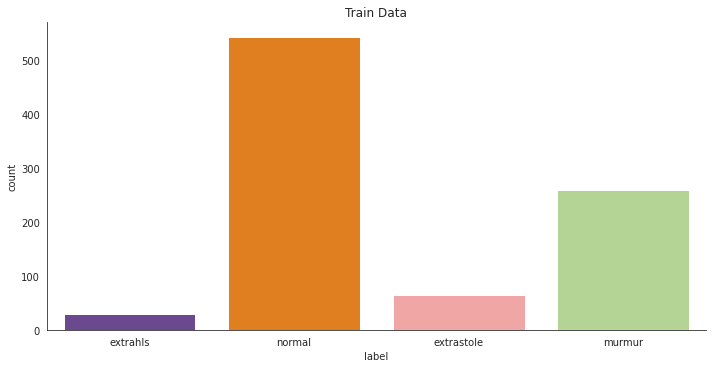

In [69]:
with sns.axes_style('white'):
    g = sns.catplot(data=train, x="label", aspect=2,
                       kind="count", palette='Paired_r')
    plt.title("Train Data")

Text(0.5, 1.0, 'Train Data')

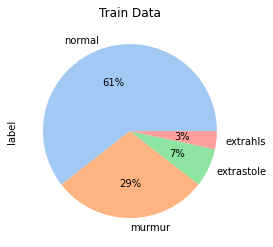

In [70]:
train['label'].value_counts(normalize=True).plot(kind='pie',colors = sns.color_palette('pastel')[0:5], autopct='%.0f%%')
plt.title("Train Data")

### Validation Data

In [71]:
val.label.value_counts()

normal        112
murmur         55
extrahls       15
extrastole     11
Name: label, dtype: int64

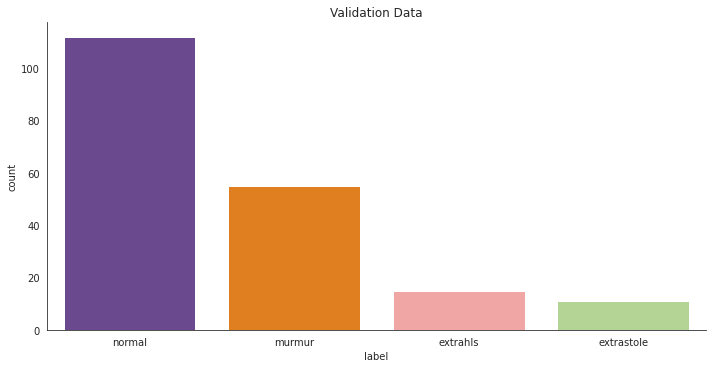

In [72]:
with sns.axes_style('white'):
    g = sns.catplot(data=val, x="label", aspect=2,
                       kind="count", palette='Paired_r')
    plt.title("Validation Data")

Text(0.5, 1.0, 'Validation Data')

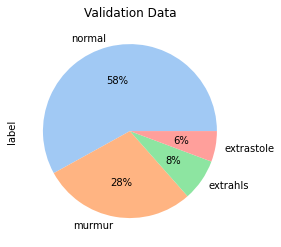

In [73]:
val['label'].value_counts(normalize=True).plot(kind='pie',colors = sns.color_palette('pastel')[0:5], autopct='%.0f%%')
plt.title("Validation Data")

### Testing Data

In [74]:
test.label.value_counts()

normal        115
murmur         59
extrastole     13
extrahls        6
Name: label, dtype: int64

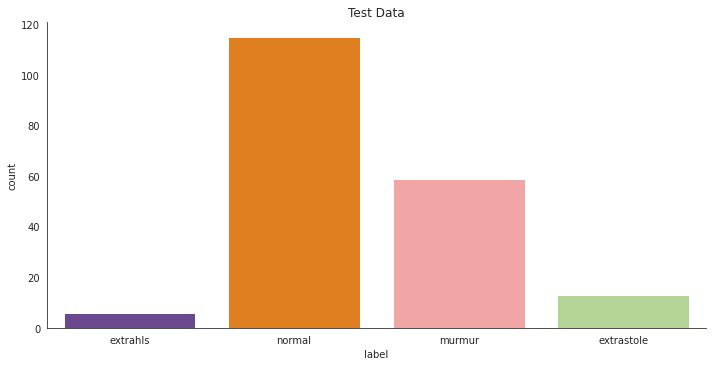

In [75]:
with sns.axes_style('white'):
    g = sns.catplot(data=test, x="label", aspect=2,
                       kind="count", palette='Paired_r')
    plt.title("Test Data")

Text(0.5, 1.0, 'Test Data')

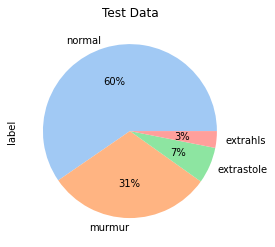

In [76]:
test['label'].value_counts(normalize=True).plot(kind='pie',colors = sns.color_palette('pastel')[0:5], autopct='%.0f%%')
plt.title("Test Data")

### Extract Features: 

In [77]:
x_train = extract_features(train)
x_test = extract_features(test)
x_val = extract_features(val)

100%|██████████| 193/193 [00:18<00:00, 10.39it/s]


In [78]:
x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)
print("X train:", x_train.shape)
print("X test:", x_test.shape)
print("X validation:", x_val.shape)

X train: (895, 40, 130)
X test: (193, 40, 130)
X validation: (193, 40, 130)


### Encoding the labels (0~3)

In [79]:
# get labels and encode them 
encoder = LabelEncoder()
encoder.fit(val.label)
y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)
y_val = encoder.transform(val.label)

***Labels***: 

*   0: Extrahls
*   1: Extrasystole
*   2: Murmur
*   3: Normal






In [80]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
# set aside for testing 
y_test = to_categorical(y_test)


In [81]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], x_val.shape[2], 1)
# set aside for testing 
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

In [82]:
print("X train:", x_train.shape)
print("Y train:", y_train.shape)
print("X val:", x_val.shape)
print("Y val:", y_val.shape)
# set aside for testing 
print("X test:", x_test.shape)
print("Y test:", y_test.shape)

X train: (895, 40, 130, 1)
Y train: (895, 4)
X val: (193, 40, 130, 1)
Y val: (193, 4)
X test: (193, 40, 130, 1)
Y test: (193, 4)


**NOTE**: Due to class imbalances, we computed the class weights

In [83]:
# Compute class weights
classWeights = compute_class_weight(
    class_weight = 'balanced', 
    classes = np.unique(train.label), 
    y = train.label) 
classWeights = dict(enumerate(classWeights))

In [84]:
print(classWeights)

{0: 7.458333333333333, 1: 3.49609375, 2: 0.8638996138996139, 3: 0.4128228782287823}


### Create a Dataframe for the results

In [88]:
results = pd.DataFrame(columns=['Architecture', 'LR','Dropout', 'Loss Fn', 'Train Acc', 'Train Loss', 'Val Acc', 'Val Loss', 'Test Acc', 'Test Loss', 'Val f1', 'Test f1', 'Average ROC'])
index = 0
results

Empty DataFrame
Columns: [Architecture, LR, Dropout, Loss Fn, Train Acc, Train Loss, Val Acc, Val Loss, Test Acc, Test Loss, Val f1, Test f1, Average ROC]
Index: []

##Suitable Loss Functions for Multi-class Classification:
1. Categorical Cross-Entropy Loss Function
2. Poisson Loss Function
3. Kullback-Leibler Divergence Loss Function(KL Divergence) 

## CNN Experiment 1:

##### **Loss Function used:** 


>**Categorical Cross Entropy:**
* The crossentropy loss between the labels and the predictions is calculated. 



In [86]:
model = Sequential()
Conv2Dmodel(model, 0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 130, 16)       160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 65, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 20, 65, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 65, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 10, 32, 32)        0

In [87]:
history, model = compile_fit(model)

Epoch 1/300
7/7 [==============================] - ETA: 0s - loss: 10.2553 - accuracy: 0.2492
Epoch 1: val_accuracy improved from -inf to 0.12435, saving model to /content/weights.best.hdf5
7/7 [==============================] - 7s 885ms/step - loss: 10.2553 - accuracy: 0.2492 - val_loss: 4.8849 - val_accuracy: 0.1244
Epoch 2/300
7/7 [==============================] - ETA: 0s - loss: 2.5720 - accuracy: 0.2358
Epoch 2: val_accuracy improved from 0.12435 to 0.58031, saving model to /content/weights.best.hdf5
7/7 [==============================] - 6s 825ms/step - loss: 2.5720 - accuracy: 0.2358 - val_loss: 0.9388 - val_accuracy: 0.5803
Epoch 3/300
7/7 [==============================] - ETA: 0s - loss: 1.5484 - accuracy: 0.4816
Epoch 3: val_accuracy did not improve from 0.58031
7/7 [==============================] - 6s 802ms/step - loss: 1.5484 - accuracy: 0.4816 - val_loss: 1.2723 - val_accuracy: 0.3420
Epoch 4/300
7/7 [==============================] - ETA: 0s - loss: 1.1165 - accuracy: 

In [89]:
results.loc[index,['Architecture','Dropout','Loss Fn', 'LR']] = ['CNN 2D',0.2, 'Cross-Entropy',0.0001] 

> **Evaluation:** Training and Validation




In [90]:
evaluation_train_val(model,x_train,y_train,x_val,y_val,results,index)

Training Accuracy:  0.9720670580863953
Training Loss:  0.09344641119241714
Validation Accuracy:  0.9481865167617798
Validation Loss:  0.2115217000246048


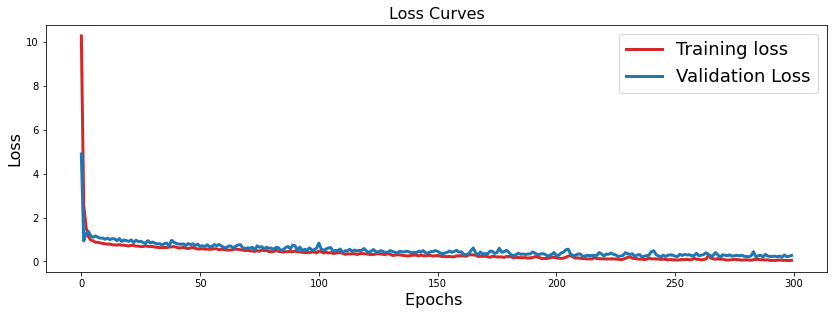

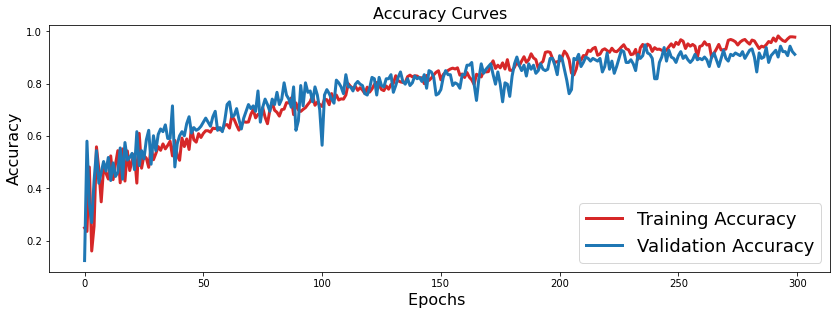

In [91]:
plotfn(history)

> **Evaluation:** Testing

In [92]:
evaluation_test(model,x_test,y_test,results,index)

7/7 [==============================] - 0s 43ms/step - loss: 0.5742 - accuracy: 0.8135
Test accuracy: 0.8134714961051941
Test loss: 0.5742360949516296




#### **Evaluation Metrics**


> F1 score

In [95]:
_,_ , _ , val_f1 = predictfn(model, x_val,y_val)

7/7 [==============================] - 1s 79ms/step
              precision    recall  f1-score   support

    extrahls       1.00      0.94      0.97        16
  extrastole       0.91      0.83      0.87        12
      murmur       0.95      0.93      0.94        56
      normal       0.95      0.97      0.96       109

    accuracy                           0.95       193
   macro avg       0.95      0.92      0.93       193
weighted avg       0.95      0.95      0.95       193



In [96]:
predictions,y_pred , y_true, test_f1 = predictfn(model, x_test,y_test)

7/7 [==============================] - 0s 41ms/step
              precision    recall  f1-score   support

    extrahls       1.00      0.40      0.57        15
  extrastole       0.54      0.78      0.64         9
      murmur       0.90      0.78      0.83        68
      normal       0.79      0.90      0.84       101

    accuracy                           0.81       193
   macro avg       0.81      0.71      0.72       193
weighted avg       0.83      0.81      0.81       193



> Confusion Matrix

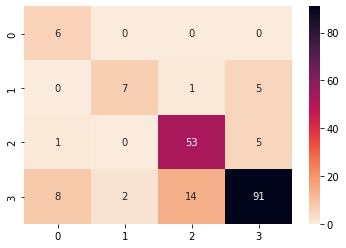

In [97]:
matrix = confusion_matrix(y_true ,y_pred)
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r')

> ROC and AUC

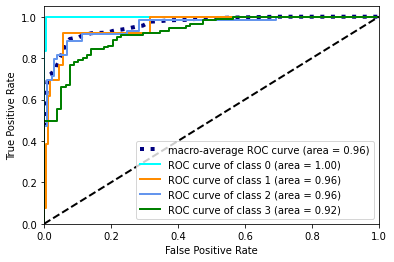

In [98]:
roc = plot_ROC(y_test,predictions)

In [99]:
results.loc[index,['Val f1','Test f1', 'Average ROC']] = [val_f1, test_f1, roc]
index = index + 1
results 

Architecture      LR Dropout        Loss Fn Train Acc Train Loss   Val Acc  \
0       CNN 2D  0.0001     0.2  Cross-Entropy  0.972067   0.093446  0.948187   

   Val Loss  Test Acc Test Loss    Val f1   Test f1 Average ROC  
0  0.211522  0.813471  0.574236  0.947918  0.809101    0.961442

#### Predicting a sample's label

In [100]:
model_name = "heartbeat_classifier2D_1.h5"
model.save(model_name)

##### Predicting a **Murmur** sample

In [108]:
test.iloc[5]

filename    /content/set_b/murmur__281_1311165683454_D.wav
label                                               murmur
offset                                                   3
Name: 997, dtype: object

In [107]:
sample_predict(model_name,5)

1/1 [==============================] - 0s 179ms/step
Label Prediction Probabilities: [[1.7005960e-15 2.7865105e-10 9.9999964e-01 3.2079288e-07]]
----------------------------------------
Label:
Murmur heartbeat
confidence: 0.99999964


##### Predicting a **Normal** sample

In [112]:
test.iloc[50]

filename    /content/set_a/normal__201101151127.wav
label                                        normal
offset                                            3
Name: 165, dtype: object

In [113]:
sample_predict(model_name,50)

1/1 [==============================] - 0s 169ms/step
Label Prediction Probabilities: [[6.0757096e-13 1.3180223e-05 3.9696847e-03 9.9601716e-01]]
----------------------------------------
Label:
Normal heartbeat
confidence: 0.99601716


##### Predicting an **Extrahls** sample

In [116]:
test.iloc[77]

filename    /content/set_a/extrahls__201101241433.wav
label                                        extrahls
offset                                              3
Name: 47, dtype: object

In [117]:
sample_predict(model_name,77)

1/1 [==============================] - 0s 164ms/step
Label Prediction Probabilities: [[9.9999630e-01 5.2413147e-19 9.6985815e-09 3.7232078e-06]]
----------------------------------------
Label:
Extrahls heartbeat
confidence: 0.9999963


##### Predicting an **Extrasystole** sample

In [140]:
test.iloc[96]

filename    /content/set_b/extrastole__207_1308159792607_B...
label                                              extrastole
offset                                                      1
Name: 990, dtype: object

In [141]:
sample_predict(model_name,96)

1/1 [==============================] - 0s 175ms/step
Label Prediction Probabilities: [[3.6787995e-04 6.6052234e-01 9.7590564e-03 3.2935071e-01]]
----------------------------------------
Label:
Extrasystole heartbeat
confidence: 0.66052234


## CNN Experiment 2: 


> Changing in Dropout layers: 



In [142]:
model = Sequential()
model.add(Conv2D(16, (3,3), padding = 'same', input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(32,(3,3), padding = 'same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.4))

model.add(Conv2D(64, (3,3), padding = 'same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.4))

model.add(Conv2D(128, (3,3), padding = 'same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(len(encoder.classes_), activation='softmax'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 40, 130, 16)       160       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 65, 16)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 20, 65, 16)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 20, 65, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 10, 32, 32)       

In [143]:
history, model = compile_fit(model)

Epoch 1/300
7/7 [==============================] - ETA: 0s - loss: 11.0311 - accuracy: 0.2939
Epoch 1: val_accuracy improved from -inf to 0.05699, saving model to /content/weights.best.hdf5
7/7 [==============================] - 7s 862ms/step - loss: 11.0311 - accuracy: 0.2939 - val_loss: 2.1939 - val_accuracy: 0.0570
Epoch 2/300
7/7 [==============================] - ETA: 0s - loss: 2.9923 - accuracy: 0.2156
Epoch 2: val_accuracy improved from 0.05699 to 0.64767, saving model to /content/weights.best.hdf5
7/7 [==============================] - 6s 800ms/step - loss: 2.9923 - accuracy: 0.2156 - val_loss: 0.9055 - val_accuracy: 0.6477
Epoch 3/300
7/7 [==============================] - ETA: 0s - loss: 1.8430 - accuracy: 0.3989
Epoch 3: val_accuracy did not improve from 0.64767
7/7 [==============================] - 5s 770ms/step - loss: 1.8430 - accuracy: 0.3989 - val_loss: 1.1665 - val_accuracy: 0.3679
Epoch 4/300
7/7 [==============================] - ETA: 0s - loss: 1.3633 - accuracy: 

In [144]:
results.loc[index,['Architecture','Dropout','Loss Fn', 'LR']] = ['CNN 2D','0.2 & 0.4', 'Cross-Entropy',0.0001] 

> **Evaluation**: Training and Validation

In [145]:
evaluation_train_val(model,x_train,y_train,x_val,y_val,results,index)

Training Accuracy:  0.9117318391799927
Training Loss:  0.30648255348205566
Validation Accuracy:  0.8601036071777344
Validation Loss:  0.3584531843662262


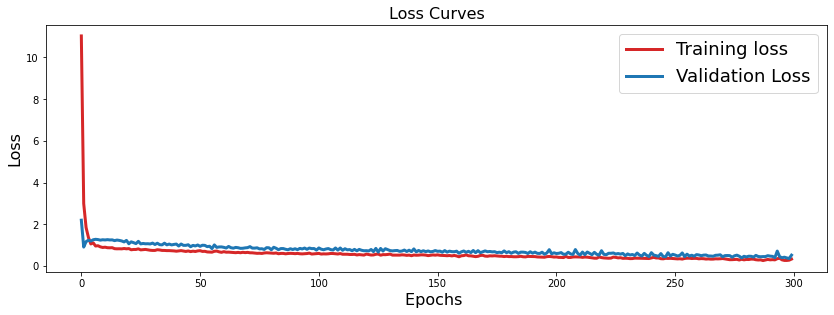

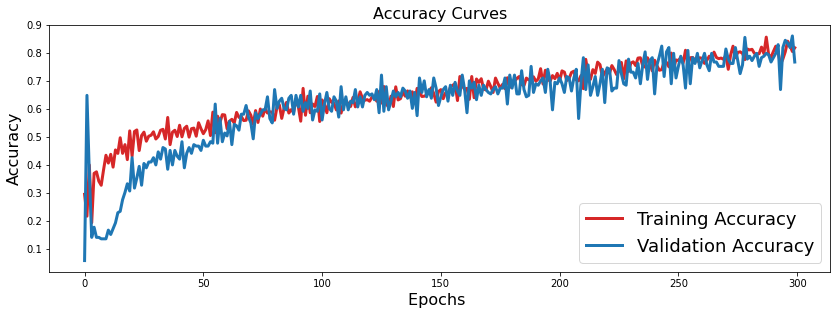

In [146]:
plotfn(history)

> **Evaluation**: Testing

In [147]:
evaluation_test(model,x_test,y_test,results,index)

7/7 [==============================] - 0s 48ms/step - loss: 0.5061 - accuracy: 0.7979
Test accuracy: 0.7979274392127991
Test loss: 0.5060573220252991


### **Evaluation Metrics**

> F1 score

In [148]:
_,_ , _ , val_f1 = predictfn(model, x_val,y_val)

7/7 [==============================] - 0s 48ms/step
              precision    recall  f1-score   support

    extrahls       0.93      0.93      0.93        15
  extrastole       0.91      0.45      0.61        22
      murmur       0.89      0.89      0.89        55
      normal       0.83      0.92      0.87       101

    accuracy                           0.86       193
   macro avg       0.89      0.80      0.83       193
weighted avg       0.86      0.86      0.85       193



In [149]:
predictions, y_pred , y_true, test_f1 = predictfn(model, x_test,y_test)

7/7 [==============================] - 0s 46ms/step
              precision    recall  f1-score   support

    extrahls       1.00      0.46      0.63        13
  extrastole       0.85      0.48      0.61        23
      murmur       0.88      0.79      0.83        66
      normal       0.74      0.93      0.83        91

    accuracy                           0.80       193
   macro avg       0.87      0.67      0.72       193
weighted avg       0.82      0.80      0.79       193



> Confusion Matrix

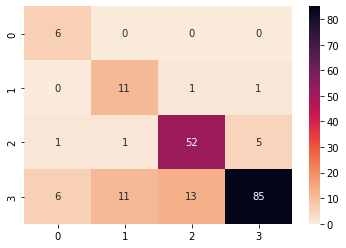

In [150]:
matrix = confusion_matrix(y_true ,y_pred)
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r')

> ROC and AUC

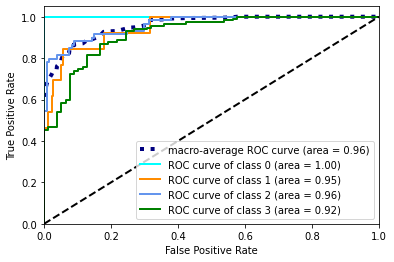

In [151]:
roc = plot_ROC(y_test,predictions)

In [152]:
results.loc[index,['Val f1','Test f1', 'Average ROC']] = [val_f1, test_f1, roc]
index = index + 1
results 

Architecture      LR    Dropout        Loss Fn Train Acc Train Loss  \
0       CNN 2D  0.0001        0.2  Cross-Entropy  0.972067   0.093446   
1       CNN 2D  0.0001  0.2 & 0.4  Cross-Entropy  0.911732   0.306483   

    Val Acc  Val Loss  Test Acc Test Loss    Val f1   Test f1 Average ROC  
0  0.948187  0.211522  0.813471  0.574236  0.947918  0.809101    0.961442  
1  0.860104  0.358453  0.797927  0.506057   0.85249  0.788991    0.959572

#### Predicting a sample's label

In [153]:
model_name = "heartbeat_classifier2D_2.h5"
model.save(model_name)

##### Predicting a **Murmur** sample

In [155]:
test.iloc[5]

filename    /content/set_b/murmur__281_1311165683454_D.wav
label                                               murmur
offset                                                   3
Name: 997, dtype: object

In [154]:
sample_predict(model_name, 5)

1/1 [==============================] - 0s 445ms/step
Label Prediction Probabilities: [[2.1426851e-05 6.7254900e-06 9.9958450e-01 3.8739174e-04]]
----------------------------------------
Label:
Murmur heartbeat
confidence: 0.9995845


##### Predicting a **Normal** sample

In [157]:
test.iloc[50]

filename    /content/set_a/normal__201101151127.wav
label                                        normal
offset                                            3
Name: 165, dtype: object

In [156]:
sample_predict(model_name,50)

1/1 [==============================] - 0s 149ms/step
Label Prediction Probabilities: [[6.2798676e-06 3.2975901e-02 2.9800212e-01 6.6901565e-01]]
----------------------------------------
Label:
Normal heartbeat
confidence: 0.66901565


##### Predicting an **Extrahls** sample

In [159]:
test.iloc[77]

filename    /content/set_a/extrahls__201101241433.wav
label                                        extrahls
offset                                              3
Name: 47, dtype: object

In [158]:
sample_predict(model_name,77)

1/1 [==============================] - 0s 132ms/step
Label Prediction Probabilities: [[9.9954081e-01 2.0443778e-16 2.3870100e-05 4.3538024e-04]]
----------------------------------------
Label:
Extrahls heartbeat
confidence: 0.9995408


##### Predicting an **Extrasystole** sample

In [161]:
test.iloc[96]

filename    /content/set_b/extrastole__207_1308159792607_B...
label                                              extrastole
offset                                                      1
Name: 990, dtype: object

In [160]:
sample_predict(model_name,96)

1/1 [==============================] - 0s 199ms/step
Label Prediction Probabilities: [[0.00722221 0.5254265  0.1157811  0.35157013]]
----------------------------------------
Label:
Extrasystole heartbeat
confidence: 0.5254265


## CNN Experiment 3: 



#### Changing in loss function:



> **Poisson Loss**
* The Poisson loss is the mean of the elements of the Tensor
* loss = y_pred - y_true * log(y_pred).





In [164]:
model = Sequential()
Conv2Dmodel(model,0.2)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 40, 130, 16)       160       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 20, 65, 16)       0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 20, 65, 16)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 20, 65, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 10, 32, 32)       0         
 g2D)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 10, 32, 32)       

In [165]:
history, model = compile_fit(model, 'poisson')

Epoch 1/300
7/7 [==============================] - ETA: 0s - loss: 2.5774 - accuracy: 0.1665
Epoch 1: val_accuracy improved from -inf to 0.05699, saving model to /content/weights.best.hdf5
7/7 [==============================] - 7s 858ms/step - loss: 2.5774 - accuracy: 0.1665 - val_loss: 3.0422 - val_accuracy: 0.0570
Epoch 2/300
7/7 [==============================] - ETA: 0s - loss: 2.4607 - accuracy: 0.1441
Epoch 2: val_accuracy improved from 0.05699 to 0.15026, saving model to /content/weights.best.hdf5
7/7 [==============================] - 5s 785ms/step - loss: 2.4607 - accuracy: 0.1441 - val_loss: 2.9194 - val_accuracy: 0.1503
Epoch 3/300
7/7 [==============================] - ETA: 0s - loss: 2.3793 - accuracy: 0.1821
Epoch 3: val_accuracy improved from 0.15026 to 0.21244, saving model to /content/weights.best.hdf5
7/7 [==============================] - 5s 790ms/step - loss: 2.3793 - accuracy: 0.1821 - val_loss: 2.7868 - val_accuracy: 0.2124
Epoch 4/300
7/7 [=======================

In [166]:
results.loc[index,['Architecture','Dropout','Loss Fn', 'LR']] = ['CNN 2D',0.2, 'Poisson',0.0001] 

> **Evaluation**: Training and Validation

In [167]:
evaluation_train_val(model,x_train,y_train,x_val,y_val,results,index)

Training Accuracy:  0.994413435459137
Training Loss:  0.023900166153907776
Validation Accuracy:  0.8963730335235596
Validation Loss:  0.3361426591873169


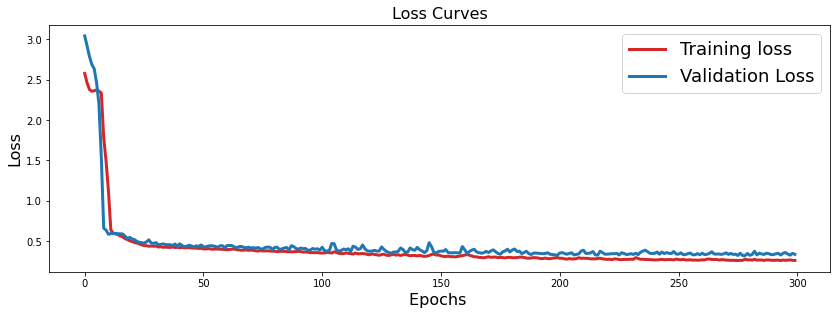

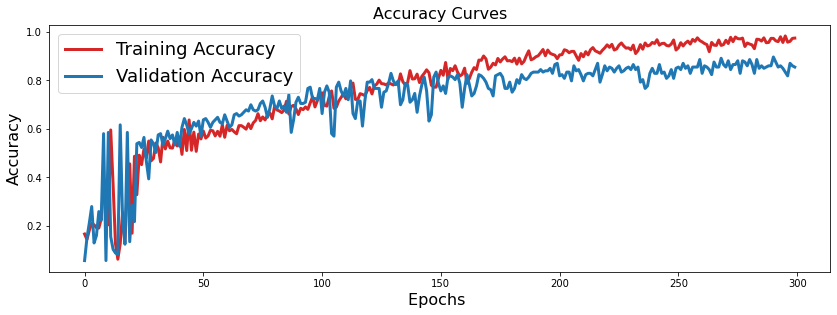

In [168]:
plotfn(history)

> **Evaluation**: Testing

In [169]:
evaluation_test(model,x_test,y_test,results,index)

7/7 [==============================] - 0s 47ms/step - loss: 0.6694 - accuracy: 0.8290
Test accuracy: 0.8290155529975891
Test loss: 0.6693798899650574


### **Evaluation Metrics**

> F1 score

In [170]:
_ , _ , _ , val_f1 = predictfn(model, x_val, y_val)

7/7 [==============================] - 0s 49ms/step
              precision    recall  f1-score   support

    extrahls       1.00      0.88      0.94        17
  extrastole       0.64      0.64      0.64        11
      murmur       0.85      0.96      0.90        49
      normal       0.93      0.90      0.91       116

    accuracy                           0.90       193
   macro avg       0.85      0.84      0.85       193
weighted avg       0.90      0.90      0.90       193



In [171]:
predictions,y_pred , y_true, test_f1 = predictfn(model,x_test,y_test)

7/7 [==============================] - 0s 46ms/step
              precision    recall  f1-score   support

    extrahls       1.00      0.50      0.67        12
  extrastole       0.62      0.67      0.64        12
      murmur       0.85      0.82      0.83        61
      normal       0.83      0.89      0.86       108

    accuracy                           0.83       193
   macro avg       0.82      0.72      0.75       193
weighted avg       0.84      0.83      0.83       193



> Confusion Matrix

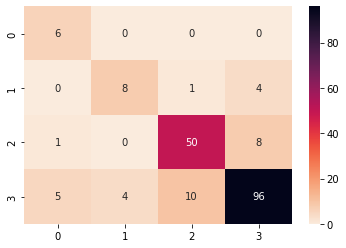

In [172]:
matrix = confusion_matrix(y_true ,y_pred)
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r')

> ROC and AUC

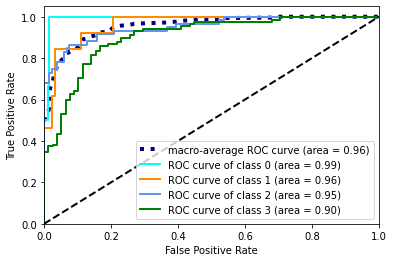

In [173]:
roc = plot_ROC(y_test,predictions)

In [174]:
results.loc[index,['Val f1','Test f1', 'Average ROC']] = [val_f1, test_f1, roc]
index = index + 1
results 

Architecture      LR    Dropout        Loss Fn Train Acc Train Loss  \
0       CNN 2D  0.0001        0.2  Cross-Entropy  0.972067   0.093446   
1       CNN 2D  0.0001  0.2 & 0.4  Cross-Entropy  0.911732   0.306483   
2       CNN 2D  0.0001        0.2        Poisson  0.994413     0.0239   

    Val Acc  Val Loss  Test Acc Test Loss    Val f1   Test f1 Average ROC  
0  0.948187  0.211522  0.813471  0.574236  0.947918  0.809101    0.961442  
1  0.860104  0.358453  0.797927  0.506057   0.85249  0.788991    0.959572  
2  0.896373  0.336143  0.829016   0.66938  0.896635  0.826424     0.95547

#### Predicting a sample's label

In [ ]:
model_name = "heartbeat_classifierLoss1.h5"
model.save(model_name)

1/1 [==============================] - 0s 137ms/step
Label Prediction Probabilities: [[9.9579092e-06 5.4306501e-01 1.4898846e-01 3.0793658e-01]]
----------------------------------------
Label:
Extrasystole heartbeat
confidence: 0.543065


##### Predicting a **Murmur** sample

In [182]:
test.iloc[5]

filename    /content/set_b/murmur__281_1311165683454_D.wav
label                                               murmur
offset                                                   3
Name: 997, dtype: object

In [175]:
sample_predict(model_name,5)

1/1 [==============================] - 0s 157ms/step
Label Prediction Probabilities: [[2.1426851e-05 6.7254900e-06 9.9958450e-01 3.8739174e-04]]
----------------------------------------
Label:
Murmur heartbeat
confidence: 0.9995845


##### Predicting a **Normal** sample

In [181]:
test.iloc[50]

filename    /content/set_a/normal__201101151127.wav
label                                        normal
offset                                            3
Name: 165, dtype: object

In [176]:
sample_predict(model_name,50)

1/1 [==============================] - 0s 150ms/step
Label Prediction Probabilities: [[6.2798676e-06 3.2975901e-02 2.9800212e-01 6.6901565e-01]]
----------------------------------------
Label:
Normal heartbeat
confidence: 0.66901565


##### Predicting an **Extrahls** sample

In [180]:
test.iloc[77]

filename    /content/set_a/extrahls__201101241433.wav
label                                        extrahls
offset                                              3
Name: 47, dtype: object

In [177]:
sample_predict(model_name,77)

1/1 [==============================] - 0s 434ms/step
Label Prediction Probabilities: [[9.9954081e-01 2.0443778e-16 2.3870100e-05 4.3538024e-04]]
----------------------------------------
Label:
Extrahls heartbeat
confidence: 0.9995408


##### Predicting a **Extrasystole** sample

In [179]:
test.iloc[96]

filename    /content/set_b/extrastole__207_1308159792607_B...
label                                              extrastole
offset                                                      1
Name: 990, dtype: object

In [178]:
sample_predict(model_name,96)

1/1 [==============================] - 0s 143ms/step
Label Prediction Probabilities: [[0.00722221 0.5254265  0.1157811  0.35157013]]
----------------------------------------
Label:
Extrasystole heartbeat
confidence: 0.5254265


## CNN Experiment 4: 


#### Changing in loss function:



> **KL Divergence**
  *  Computes Kullback-Leibler divergence loss between y_true and y_pred.
  *  loss = y_true * log(y_true / y_pred)







In [191]:
model = Sequential()
Conv2Dmodel(model,0.2)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 40, 130, 16)       160       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 20, 65, 16)       0         
 g2D)                                                            
                                                                 
 dropout_25 (Dropout)        (None, 20, 65, 16)        0         
                                                                 
 conv2d_33 (Conv2D)          (None, 20, 65, 32)        4640      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 10, 32, 32)       0         
 g2D)                                                            
                                                                 
 dropout_26 (Dropout)        (None, 10, 32, 32)       

In [192]:
history, model = compile_fit(model,keras.losses.kullback_leibler_divergence)

Epoch 1/300
7/7 [==============================] - ETA: 0s - loss: 9.9506 - accuracy: 0.3251
Epoch 1: val_accuracy improved from -inf to 0.58031, saving model to /content/weights.best.hdf5
7/7 [==============================] - 7s 841ms/step - loss: 9.9506 - accuracy: 0.3251 - val_loss: 3.8814 - val_accuracy: 0.5803
Epoch 2/300
7/7 [==============================] - ETA: 0s - loss: 10.0764 - accuracy: 0.4045
Epoch 2: val_accuracy did not improve from 0.58031
7/7 [==============================] - 6s 807ms/step - loss: 10.0764 - accuracy: 0.4045 - val_loss: 2.7777 - val_accuracy: 0.4663
Epoch 3/300
7/7 [==============================] - ETA: 0s - loss: 8.8032 - accuracy: 0.5620
Epoch 3: val_accuracy did not improve from 0.58031
7/7 [==============================] - 5s 760ms/step - loss: 8.8032 - accuracy: 0.5620 - val_loss: 3.0635 - val_accuracy: 0.2953
Epoch 4/300
7/7 [==============================] - ETA: 0s - loss: 8.6460 - accuracy: 0.4089
Epoch 4: val_accuracy improved from 0.580

In [204]:
results.loc[index,['Architecture','Dropout','Loss Fn', 'LR']] = ['CNN 2D',0.2, 'KL divergence',0.0001] 

> **Evaluation**: Training and Validation

In [205]:
evaluation_train_val(model,x_train,y_train,x_val,y_val,results,index)

Training Accuracy:  0.9843575358390808
Training Loss:  0.07990801334381104
Validation Accuracy:  0.9119170904159546
Validation Loss:  0.28500333428382874


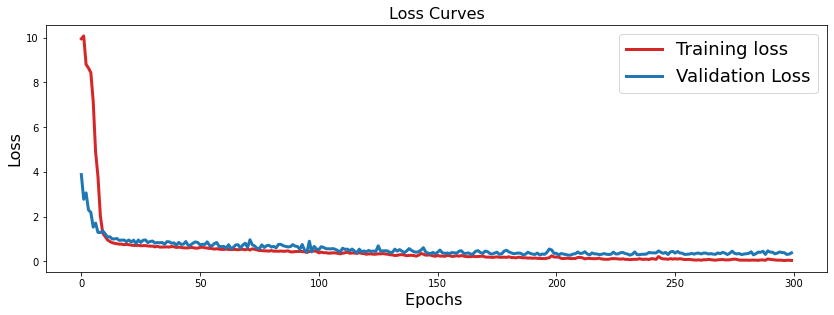

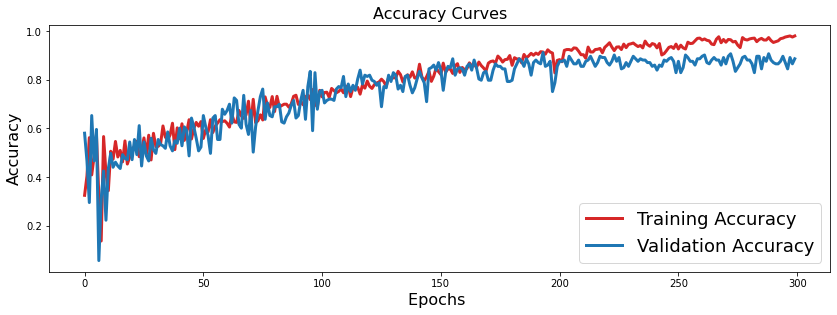

In [195]:
plotfn(history)

> **Evaluation**: Testing

In [206]:
evaluation_test(model,x_test,y_test,results,index)

7/7 [==============================] - 0s 49ms/step - loss: 0.5086 - accuracy: 0.7979
Test accuracy: 0.7979274392127991
Test loss: 0.508575439453125


### **Evaluation Metrics**

> F1 score

In [207]:
_ , _ , _ , val_f1 = predictfn(model, x_val,y_val)

7/7 [==============================] - 0s 48ms/step
              precision    recall  f1-score   support

    extrahls       1.00      0.94      0.97        16
  extrastole       0.91      0.67      0.77        15
      murmur       0.84      0.96      0.89        48
      normal       0.94      0.92      0.93       114

    accuracy                           0.91       193
   macro avg       0.92      0.87      0.89       193
weighted avg       0.92      0.91      0.91       193



In [208]:
predictions,y_pred , y_true, test_f1 = predictfn(model,x_test,y_test)

7/7 [==============================] - 0s 51ms/step
              precision    recall  f1-score   support

    extrahls       1.00      0.55      0.71        11
  extrastole       0.46      0.60      0.52        10
      murmur       0.76      0.80      0.78        56
      normal       0.84      0.84      0.84       116

    accuracy                           0.80       193
   macro avg       0.77      0.70      0.71       193
weighted avg       0.81      0.80      0.80       193



> Confusion Matrix

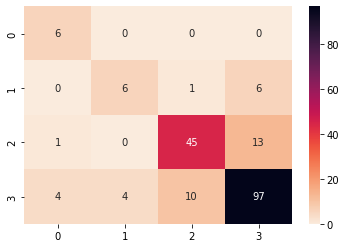

In [209]:
matrix = confusion_matrix(y_true ,y_pred)
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r')

> ROC and AUC

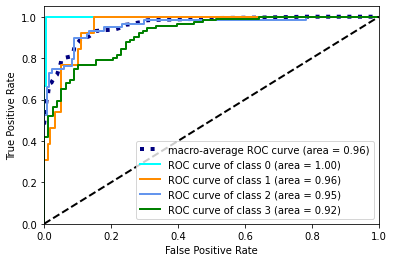

In [210]:
roc = plot_ROC(y_test,predictions)

In [211]:
results.loc[index,['Val f1','Test f1', 'Average ROC']] = [val_f1, test_f1, roc]
index = index + 1
results 

Architecture      LR    Dropout        Loss Fn Train Acc Train Loss  \
0       CNN 2D  0.0001        0.2  Cross-Entropy  0.972067   0.093446   
1       CNN 2D  0.0001  0.2 & 0.4  Cross-Entropy  0.911732   0.306483   
2       CNN 2D  0.0001        0.2        Poisson  0.994413     0.0239   
3       CNN 2D  0.0001        0.2  KL divergence  0.984358   0.079908   

    Val Acc  Val Loss  Test Acc Test Loss    Val f1   Test f1 Average ROC  
0  0.948187  0.211522  0.813471  0.574236  0.947918  0.809101    0.961442  
1  0.860104  0.358453  0.797927  0.506057   0.85249  0.788991    0.959572  
2  0.896373  0.336143  0.829016   0.66938  0.896635  0.826424     0.95547  
3  0.911917  0.285003  0.797927  0.508575  0.911012  0.799109    0.958595

#### Predicting a sample's label



In [212]:
model_name = "heartbeat_classifierLoss2.h5"
model.save(model_name)

##### Predicting a **Murmur** sample

In [ ]:
test.iloc[5]

filename    /content/set_b/murmur__281_1311165683454_D.wav
label                                               murmur
offset                                                   3
Name: 997, dtype: object

In [ ]:
sample_predict(model_name,5)

1/1 [==============================] - 0s 115ms/step
Label Prediction Probabilities: [[4.8394353e-14 3.7032809e-08 9.9999821e-01 1.7589922e-06]]
----------------------------------------
Label:
Murmur heartbeat
confidence: 0.9999982


##### Predicting a **Normal** sample

In [ ]:
test.iloc[50]

filename    /content/set_a/normal__201101151127.wav
label                                        normal
offset                                            3
Name: 165, dtype: object

In [ ]:
sample_predict(model_name,50)

1/1 [==============================] - 0s 138ms/step
Label Prediction Probabilities: [[9.8032991e-11 6.7754503e-04 1.0603091e-02 9.8871940e-01]]
----------------------------------------
Label:
Normal heartbeat
confidence: 0.9887194


##### Predicting an **Extrahls** sample

In [ ]:
test.iloc[77]

filename    /content/set_a/extrahls__201101241433.wav
label                                        extrahls
offset                                              3
Name: 47, dtype: object

In [ ]:
sample_predict(model_name,77)

1/1 [==============================] - 0s 107ms/step
Label Prediction Probabilities: [[9.9960083e-01 2.2478001e-17 3.9711951e-05 3.5947931e-04]]
----------------------------------------
Label:
Extrahls heartbeat
confidence: 0.9996008


##### Predicting a **Extrasystole** sample

In [ ]:
test.iloc[24]

filename    /content/set_b/extrastole__191_1308077299430_A...
label                                              extrastole
offset                                                      7
Name: 626, dtype: object

In [ ]:
sample_predict(model_name,24)

1/1 [==============================] - 0s 157ms/step
Label Prediction Probabilities: [[4.8668443e-09 7.7158499e-01 7.7761692e-04 2.2763738e-01]]
----------------------------------------
Label:
Extrasystole heartbeat
confidence: 0.771585


## CNN Experiment 4: 
#### Change in Learning Rate:

In [266]:
model = Sequential()
Conv2Dmodel(model,0.2)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 40, 130, 16)       160       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 20, 65, 16)       0         
 g2D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 20, 65, 16)        0         
                                                                 
 conv2d_37 (Conv2D)          (None, 20, 65, 32)        4640      
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 10, 32, 32)       0         
 g2D)                                                            
                                                                 
 dropout_29 (Dropout)        (None, 10, 32, 32)       

In [267]:
history, model = compile_fit(model,LR = 0.001)

Epoch 1/300
7/7 [==============================] - ETA: 0s - loss: 11.0827 - accuracy: 0.2078
Epoch 1: val_accuracy improved from -inf to 0.12435, saving model to /content/weights.best.hdf5
7/7 [==============================] - 8s 1s/step - loss: 11.0827 - accuracy: 0.2078 - val_loss: 2.8751 - val_accuracy: 0.1244
Epoch 2/300
7/7 [==============================] - ETA: 0s - loss: 2.4317 - accuracy: 0.3397
Epoch 2: val_accuracy improved from 0.12435 to 0.58031, saving model to /content/weights.best.hdf5
7/7 [==============================] - 7s 1s/step - loss: 2.4317 - accuracy: 0.3397 - val_loss: 1.1836 - val_accuracy: 0.5803
Epoch 3/300
7/7 [==============================] - ETA: 0s - loss: 1.4037 - accuracy: 0.4402
Epoch 3: val_accuracy did not improve from 0.58031
7/7 [==============================] - 9s 1s/step - loss: 1.4037 - accuracy: 0.4402 - val_loss: 1.4156 - val_accuracy: 0.2953
Epoch 4/300
7/7 [==============================] - ETA: 0s - loss: 1.2013 - accuracy: 0.2816
Ep

In [268]:
results.loc[index,['Architecture','Dropout','Loss Fn', 'LR']] = ['CNN 2D',0.2, 'Cross-Entropy',0.001] 

> **Evaluation:** Training and Validation



In [269]:
evaluation_train_val(model,x_train,y_train,x_val,y_val,results,index)

Training Accuracy:  0.994413435459137
Training Loss:  0.0216680895537138
Validation Accuracy:  0.9170984625816345
Validation Loss:  0.2732197940349579


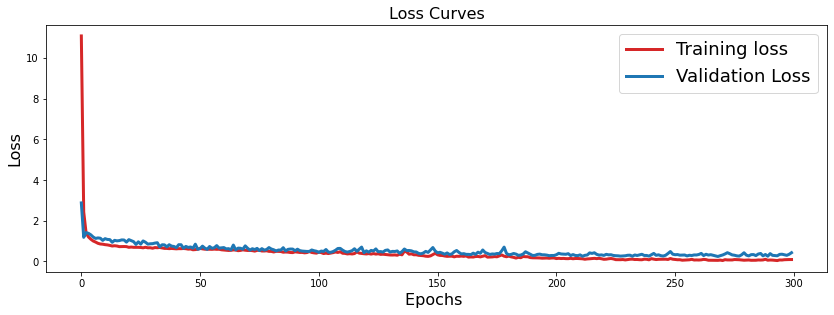

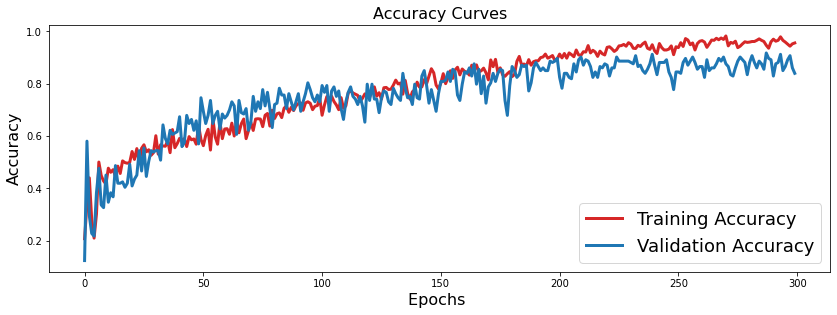

In [270]:
plotfn(history)

> **Evaluation:** Testing

In [271]:
evaluation_test(model,x_test,y_test,results,index)

7/7 [==============================] - 0s 52ms/step - loss: 0.5668 - accuracy: 0.8342
Test accuracy: 0.8341968655586243
Test loss: 0.5668305158615112


### **Evaluation Metrics**


> F1 Score


In [272]:
_ , _ , _ , val_f1 = predictfn(model, x_val, y_val)

7/7 [==============================] - 0s 50ms/step
              precision    recall  f1-score   support

    extrahls       0.93      1.00      0.97        14
  extrastole       0.73      0.80      0.76        10
      murmur       0.85      0.96      0.90        49
      normal       0.96      0.90      0.93       120

    accuracy                           0.92       193
   macro avg       0.87      0.91      0.89       193
weighted avg       0.92      0.92      0.92       193



In [273]:
predictions, y_pred , y_true, test_f1 = predictfn(model,x_test,y_test)

7/7 [==============================] - 0s 43ms/step
              precision    recall  f1-score   support

    extrahls       1.00      0.50      0.67        12
  extrastole       0.38      0.83      0.53         6
      murmur       0.85      0.85      0.85        59
      normal       0.87      0.86      0.87       116

    accuracy                           0.83       193
   macro avg       0.78      0.76      0.73       193
weighted avg       0.86      0.83      0.84       193



> Confusion Matrix

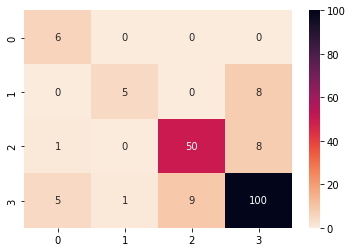

In [274]:
matrix = confusion_matrix(y_true ,y_pred)
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r')

> ROC and AUC

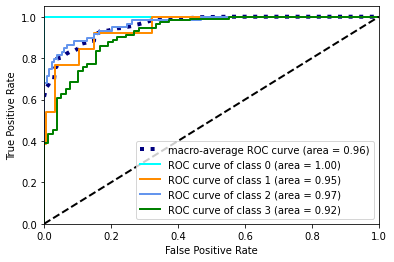

In [275]:
roc = plot_ROC(y_test,predictions)

In [276]:
results.loc[index,['Val f1','Test f1', 'Average ROC']] = [val_f1, test_f1, roc]
index = index + 1
results 

Architecture      LR    Dropout        Loss Fn Train Acc Train Loss  \
0       CNN 2D  0.0001        0.2  Cross-Entropy  0.972067   0.093446   
1       CNN 2D  0.0001  0.2 & 0.4  Cross-Entropy  0.911732   0.306483   
2       CNN 2D  0.0001        0.2        Poisson  0.994413     0.0239   
3       CNN 2D  0.0001        0.2  KL divergence  0.984358   0.079908   
4       CNN 2D   0.001        0.2  Cross-Entropy  0.994413   0.021668   

    Val Acc  Val Loss  Test Acc Test Loss    Val f1   Test f1 Average ROC  
0  0.948187  0.211522  0.813471  0.574236  0.947918  0.809101    0.961442  
1  0.860104  0.358453  0.797927  0.506057   0.85249  0.788991    0.959572  
2  0.896373  0.336143  0.829016   0.66938  0.896635  0.826424     0.95547  
3  0.911917  0.285003  0.797927  0.508575  0.911012  0.799109    0.958595  
4  0.917098   0.27322  0.834197  0.566831   0.91787  0.837258    0.960526

#### Predicting a sample's label

In [277]:
model_name = "heartbeat_classifierLR1.h5"
model.save(model_name)

##### Predicting a **Murmur** sample

In [286]:
test.iloc[5]

filename    /content/set_b/murmur__281_1311165683454_D.wav
label                                               murmur
offset                                                   3
Name: 997, dtype: object

In [278]:
sample_predict(model_name,5)

1/1 [==============================] - 0s 110ms/step
Label Prediction Probabilities: [[3.7826599e-17 7.1827141e-11 9.9999940e-01 5.7285536e-07]]
----------------------------------------
Label:
Murmur heartbeat
confidence: 0.9999994


##### Predicting a **Normal** sample

In [287]:
test.iloc[50]

filename    /content/set_a/normal__201101151127.wav
label                                        normal
offset                                            3
Name: 165, dtype: object

In [279]:
sample_predict(model_name,50)

1/1 [==============================] - 0s 128ms/step
Label Prediction Probabilities: [[7.3693432e-14 2.4881882e-07 4.0197882e-04 9.9959785e-01]]
----------------------------------------
Label:
Normal heartbeat
confidence: 0.99959785


##### Predicting an **Extrahls** sample

In [285]:
test.iloc[77]

filename    /content/set_a/extrahls__201101241433.wav
label                                        extrahls
offset                                              3
Name: 47, dtype: object

In [280]:
sample_predict(model_name,77)

1/1 [==============================] - 0s 114ms/step
Label Prediction Probabilities: [[9.9999988e-01 1.6705131e-21 4.6154835e-08 1.4859177e-07]]
----------------------------------------
Label:
Extrahls heartbeat
confidence: 0.9999999


##### Predicting a **Extrasystole** sample

In [284]:
test.iloc[24] 

filename    /content/set_b/extrastole__191_1308077299430_A...
label                                              extrastole
offset                                                      7
Name: 626, dtype: object

In [283]:
sample_predict(model_name,24)

1/1 [==============================] - 0s 220ms/step
Label Prediction Probabilities: [[8.3386587e-10 9.1592801e-01 6.2330805e-06 8.4065810e-02]]
----------------------------------------
Label:
Extrasystole heartbeat
confidence: 0.915928


## CNN Experiment 3: CONV1D

In [288]:
model = Sequential()
model.add(Conv1D(filters=16, kernel_size=3, padding = 'same' ,input_shape=(x_train.shape[1],x_train.shape[2]), activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.2))

model.add(Conv1D(filters=32, kernel_size=3,padding = 'same' , activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.2))

model.add(Conv1D(filters=64, kernel_size=3,padding = 'same' ,  activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.2))

model.add(Conv1D(filters=128, kernel_size=3,padding = 'same' ,  activation='relu'))
model.add(MaxPooling1D())
model.add(GlobalAveragePooling1D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(len(encoder.classes_), activation='softmax'))
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 16)            6256      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 20, 16)           0         
 )                                                               
                                                                 
 dropout_31 (Dropout)        (None, 20, 16)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 32)            1568      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 10, 32)           0         
 1D)                                                             
                                                                 
 dropout_32 (Dropout)        (None, 10, 32)          

In [289]:
history, model = compile_fit(model)

Epoch 1/300
7/7 [==============================] - ETA: 0s - loss: 8.8861 - accuracy: 0.2402 
Epoch 1: val_accuracy improved from -inf to 0.36788, saving model to /content/weights.best.hdf5
7/7 [==============================] - 2s 105ms/step - loss: 8.8861 - accuracy: 0.2402 - val_loss: 1.5049 - val_accuracy: 0.3679
Epoch 2/300
7/7 [==============================] - ETA: 0s - loss: 3.1817 - accuracy: 0.4156
Epoch 2: val_accuracy did not improve from 0.36788
7/7 [==============================] - 0s 54ms/step - loss: 3.1817 - accuracy: 0.4156 - val_loss: 1.6522 - val_accuracy: 0.3109
Epoch 3/300
6/7 [========================>.....] - ETA: 0s - loss: 2.2242 - accuracy: 0.2083
Epoch 3: val_accuracy did not improve from 0.36788
7/7 [==============================] - 0s 53ms/step - loss: 2.2253 - accuracy: 0.1933 - val_loss: 1.9723 - val_accuracy: 0.1244
Epoch 4/300
7/7 [==============================] - ETA: 0s - loss: 1.7137 - accuracy: 0.2615
Epoch 4: val_accuracy improved from 0.36788 

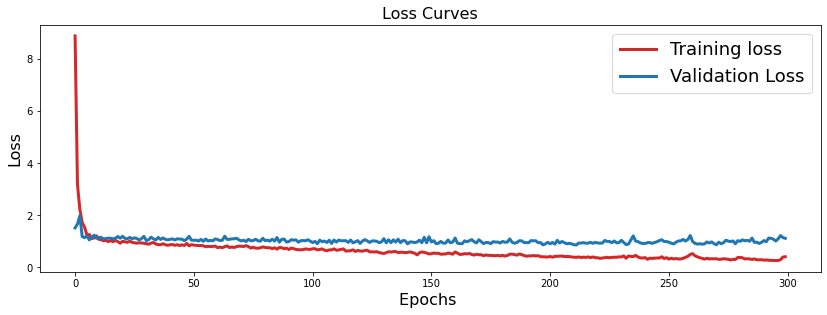

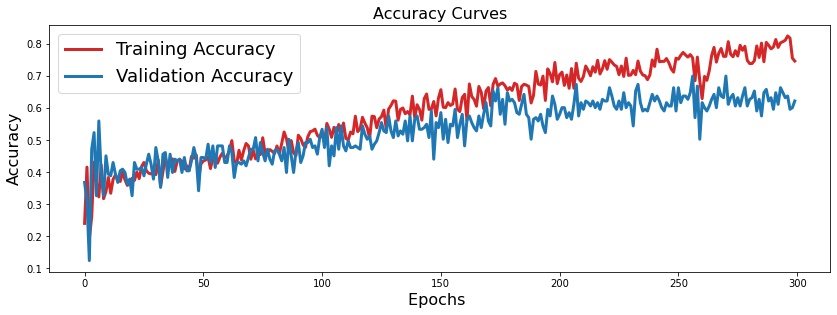

In [290]:
plotfn(history)

In [291]:
results.loc[index,['Architecture','Dropout','Loss Fn', 'LR']] = ['CNN 1D',0.2, 'Cross-Entropy',0.0001] 

> **Evaluation:** Training and Validation



In [292]:
evaluation_train_val(model,x_train,y_train,x_val,y_val, results, index)

Training Accuracy:  0.832402229309082
Training Loss:  0.4133915901184082
Validation Accuracy:  0.6994818449020386
Validation Loss:  1.0621323585510254


> **Evaluation:** Testing 

In [293]:
evaluation_test(model,x_test,y_test, results, index)

7/7 [==============================] - 0s 5ms/step - loss: 1.1640 - accuracy: 0.6166
Test accuracy: 0.6165803074836731
Test loss: 1.1640427112579346



### **Evaluation Metrics**


> F1 score

In [294]:
_ ,_ , _ , val_f1 = predictfn(model, x_val,y_val)

7/7 [==============================] - 30s 6ms/step
              precision    recall  f1-score   support

    extrahls       0.93      0.82      0.87        17
  extrastole       0.09      0.08      0.09        12
      murmur       0.51      0.74      0.60        38
      normal       0.82      0.73      0.77       126

    accuracy                           0.70       193
   macro avg       0.59      0.59      0.58       193
weighted avg       0.72      0.70      0.71       193



In [295]:
predictions,y_pred , y_true, test_f1 = predictfn(model,x_test,y_test)

7/7 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

    extrahls       1.00      0.29      0.44        21
  extrastole       0.15      0.14      0.15        14
      murmur       0.58      0.71      0.64        48
      normal       0.67      0.70      0.68       110

    accuracy                           0.62       193
   macro avg       0.60      0.46      0.48       193
weighted avg       0.64      0.62      0.61       193



> Confusion Matrix

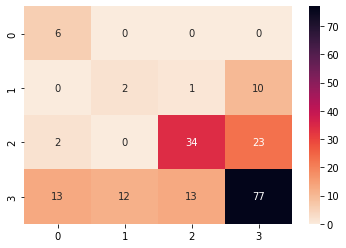

In [296]:
matrix = confusion_matrix(y_true ,y_pred)
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r')

> ROC and AUC

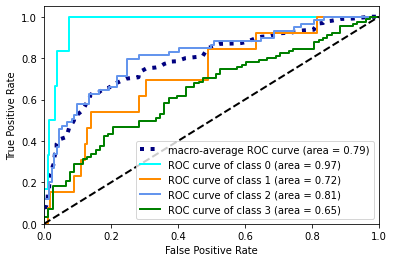

In [297]:
roc = plot_ROC(y_test,predictions)

In [298]:
results.loc[index,['Val f1','Test f1', 'Average ROC']] = [val_f1, test_f1, roc]
index = index + 1
results

Architecture      LR    Dropout        Loss Fn Train Acc Train Loss  \
0       CNN 2D  0.0001        0.2  Cross-Entropy  0.972067   0.093446   
1       CNN 2D  0.0001  0.2 & 0.4  Cross-Entropy  0.911732   0.306483   
2       CNN 2D  0.0001        0.2        Poisson  0.994413     0.0239   
3       CNN 2D  0.0001        0.2  KL divergence  0.984358   0.079908   
4       CNN 2D   0.001        0.2  Cross-Entropy  0.994413   0.021668   
5       CNN 1D  0.0001        0.2  Cross-Entropy  0.832402   0.413392   

    Val Acc  Val Loss  Test Acc Test Loss    Val f1   Test f1 Average ROC  
0  0.948187  0.211522  0.813471  0.574236  0.947918  0.809101    0.961442  
1  0.860104  0.358453  0.797927  0.506057   0.85249  0.788991    0.959572  
2  0.896373  0.336143  0.829016   0.66938  0.896635  0.826424     0.95547  
3  0.911917  0.285003  0.797927  0.508575  0.911012  0.799109    0.958595  
4  0.917098   0.27322  0.834197  0.566831   0.91787  0.837258    0.960526  
5  0.699482  1.062132   0.61658  1.164043  0.705761  0.607259    0.791756

***COMMENTS:***
> We observed that CONV 1D performance was mediocre as presented by the confusion matrix that most of the samples of class 1 and 2 were misclassified. The previous models had better results.

#### Predicting a sample's label

In [299]:
model_name = "heartbeat_classifier1D_1.h5"
model.save(model_name)

##### Predicting a **Murmur** sample

In [309]:
test.iloc[5]

filename    /content/set_b/murmur__281_1311165683454_D.wav
label                                               murmur
offset                                                   3
Name: 997, dtype: object

In [300]:
sample_predict(model_name,5)

1/1 [==============================] - 0s 154ms/step
Label Prediction Probabilities: [[1.2026994e-09 3.7738516e-06 7.1122938e-01 2.8876674e-01]]
----------------------------------------
Label:
Murmur heartbeat
confidence: 0.7112294


##### Predicting a **Normal** sample

In [308]:
test.iloc[50]

filename    /content/set_a/normal__201101151127.wav
label                                        normal
offset                                            3
Name: 165, dtype: object

In [301]:
sample_predict(model_name,50)

1/1 [==============================] - 0s 199ms/step
Label Prediction Probabilities: [[3.3338239e-08 2.8064102e-03 3.5869348e-01 6.3850003e-01]]
----------------------------------------
Label:
Normal heartbeat
confidence: 0.63850003


##### Predicting an **Extrahls** sample

In [307]:
test.iloc[77]

filename    /content/set_a/extrahls__201101241433.wav
label                                        extrahls
offset                                              3
Name: 47, dtype: object

In [302]:
sample_predict(model_name,77)

1/1 [==============================] - 0s 157ms/step
Label Prediction Probabilities: [[9.7751039e-01 1.4232057e-07 6.6392007e-04 2.1825645e-02]]
----------------------------------------
Label:
Extrahls heartbeat
confidence: 0.9775104


##### Predicting a **Extrasystole** sample

In [305]:
test.iloc[16] 

filename    /content/set_b/extrastole__140_1306519735121_D...
label                                              extrastole
offset                                                      1
Name: 245, dtype: object

In [306]:
sample_predict(model_name,16)

1/1 [==============================] - 0s 229ms/step
Label Prediction Probabilities: [[1.8655954e-11 9.8336029e-01 2.4054985e-04 1.6399171e-02]]
----------------------------------------
Label:
Extrasystole heartbeat
confidence: 0.9833603




---



## ANN Experiment (Feed-forward Network): Multi-layer Perceptron (MLP)

In [310]:
# for training data
X_train = extract_features_helper(train_1)
X_train = np.array(X_train)
print("X train:", X_train.shape)
# for validation data
X_val = extract_features_helper(val)
X_val = np.array(X_val)
print("X validation:", X_val.shape)
# for testing data
X_test = extract_features_helper(test)
X_test = np.array(X_test)
print("X testing:", X_test.shape)

100%|██████████| 1088/1088 [01:10<00:00, 15.50it/s]


X train: (1088, 40)


100%|██████████| 193/193 [00:19<00:00,  9.83it/s]


X validation: (193, 40)


100%|██████████| 193/193 [00:19<00:00, 10.15it/s]

X testing: (193, 40)


In [311]:
# encode the labels
encoder = LabelEncoder()
encoder.fit(test.label)
Y_train = encoder.transform(train_1.label)
Y_train = to_categorical(Y_train)
Y_test = encoder.transform(test.label)
Y_test = to_categorical(Y_test)
Y_val = encoder.transform(val.label)
Y_val = to_categorical(Y_val)
X_train = np.array(X_train)
Y_train = np.array(Y_train)

## ANN Experiment 1:

In [312]:
model = Sequential()
model.add(Dense(32, input_shape = (X_train[1].shape), activation = "relu" ))
model.add(Dense(16, activation = "relu"))
model.add(Dense(8, activation = "relu"))
model.add(Dense(4, activation = "relu"))
model.add(Dropout(0.1))
model.add(Dense(len(encoder.classes_), activation = "softmax"))
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 32)                1312      
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dense_14 (Dense)            (None, 8)                 136       
                                                                 
 dense_15 (Dense)            (None, 4)                 36        
                                                                 
 dropout_35 (Dropout)        (None, 4)                 0         
                                                                 
 dense_16 (Dense)            (None, 4)                 20        
                                                                 
Total params: 2,032
Trainable params: 2,032
Non-train

In [313]:
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
filepath="/content/weightsMLP1.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(X_train, Y_train, epochs=300, batch_size=128, verbose=1, validation_split=0.17647059, shuffle=True, callbacks = [checkpoint], class_weight=classWeights)

Epoch 1/300
1/7 [===>..........................] - ETA: 4s - loss: 76.9249 - accuracy: 0.5547
Epoch 1: val_accuracy improved from -inf to 0.58549, saving model to /content/weightsMLP1.best.hdf5
7/7 [==============================] - 1s 57ms/step - loss: 77.6899 - accuracy: 0.5497 - val_loss: 34.1105 - val_accuracy: 0.5855
Epoch 2/300
1/7 [===>..........................] - ETA: 0s - loss: 60.2220 - accuracy: 0.5625
Epoch 2: val_accuracy did not improve from 0.58549
7/7 [==============================] - 0s 9ms/step - loss: 55.0785 - accuracy: 0.5464 - val_loss: 22.8973 - val_accuracy: 0.5855
Epoch 3/300
1/7 [===>..........................] - ETA: 0s - loss: 38.6671 - accuracy: 0.5391
Epoch 3: val_accuracy did not improve from 0.58549
7/7 [==============================] - 0s 8ms/step - loss: 34.4784 - accuracy: 0.5486 - val_loss: 12.9843 - val_accuracy: 0.5855
Epoch 4/300
1/7 [===>..........................] - ETA: 0s - loss: 24.1464 - accuracy: 0.5312
Epoch 4: val_accuracy did not impr

In [314]:
model.load_weights("/content/weightsMLP1.best.hdf5")
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy' , metrics=['accuracy'], optimizer='adam')
print("Created model and loaded weights from file")

Created model and loaded weights from file


In [315]:
results.loc[index,['Architecture','Dropout','Loss Fn', 'LR']] = ['ANN: MLP',0.1, 'Cross-Entropy',0.0001] 

> **Evaluation:** Training and Validation



In [316]:
evaluation_train_val(model,X_train,Y_train,X_val,Y_val,results, index)

Training Accuracy:  0.642463207244873
Training Loss:  0.8273573517799377
Validation Accuracy:  0.6994818449020386
Validation Loss:  0.7287982106208801


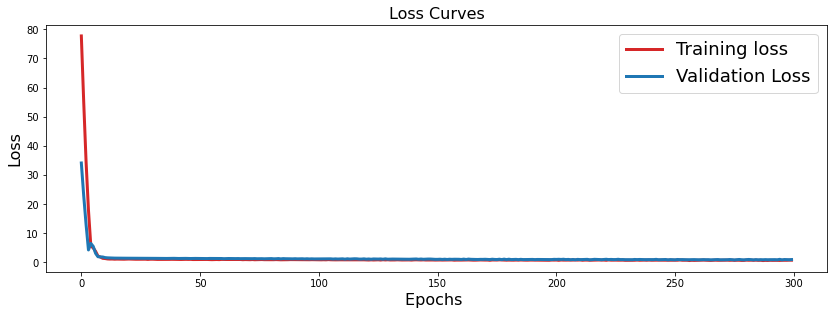

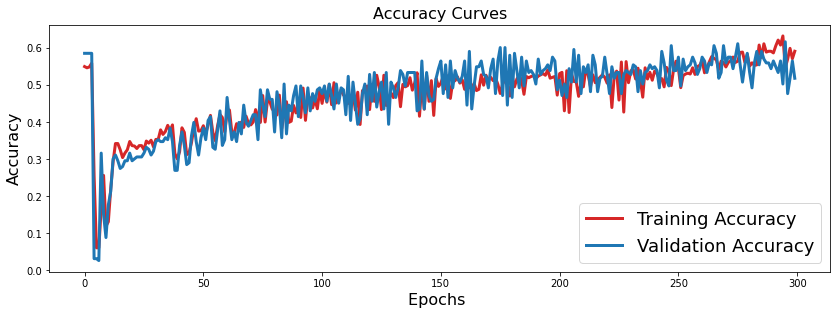

In [317]:
plotfn(history)

> **Evaluation:** Testing

In [318]:
evaluation_test(model, X_test, Y_test, results, index)

7/7 [==============================] - 0s 2ms/step - loss: 0.9861 - accuracy: 0.5648
Test accuracy: 0.5647668242454529
Test loss: 0.9860582947731018



### **Evaluation Metrics**


> F1 score

In [319]:
_,_ , _ , val_f1 = predictfn(model, X_val,Y_val)

7/7 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

    extrahls       1.00      0.83      0.91        18
  extrastole       0.73      0.36      0.48        22
      murmur       0.84      0.60      0.70        77
      normal       0.59      0.87      0.70        76

    accuracy                           0.70       193
   macro avg       0.79      0.67      0.70       193
weighted avg       0.74      0.70      0.69       193



In [320]:
predictions,y_pred , y_true, test_f1 = predictfn(model,X_test,Y_test)

7/7 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

    extrahls       1.00      0.30      0.46        20
  extrastole       0.54      0.26      0.35        27
      murmur       0.64      0.56      0.60        68
      normal       0.50      0.74      0.60        78

    accuracy                           0.56       193
   macro avg       0.67      0.47      0.50       193
weighted avg       0.61      0.56      0.55       193



> Confusion Matrix

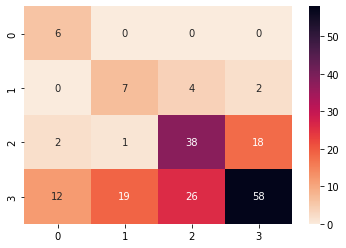

In [321]:
matrix = confusion_matrix(y_true ,y_pred)
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r')

> ROC and AUC

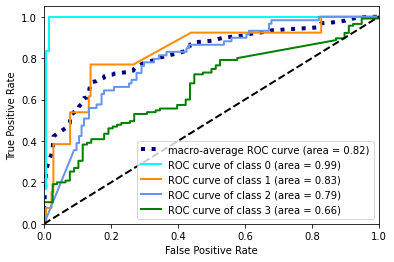

In [322]:
roc = plot_ROC(Y_test,predictions)

In [323]:
results.loc[index,['Val f1','Test f1', 'Average ROC']] = [val_f1, test_f1, roc]
index = index + 1
results 

Architecture      LR    Dropout        Loss Fn Train Acc Train Loss  \
0       CNN 2D  0.0001        0.2  Cross-Entropy  0.972067   0.093446   
1       CNN 2D  0.0001  0.2 & 0.4  Cross-Entropy  0.911732   0.306483   
2       CNN 2D  0.0001        0.2        Poisson  0.994413     0.0239   
3       CNN 2D  0.0001        0.2  KL divergence  0.984358   0.079908   
4       CNN 2D   0.001        0.2  Cross-Entropy  0.994413   0.021668   
5       CNN 1D  0.0001        0.2  Cross-Entropy  0.832402   0.413392   
6     ANN: MLP  0.0001        0.1  Cross-Entropy  0.642463   0.827357   

    Val Acc  Val Loss  Test Acc Test Loss    Val f1   Test f1 Average ROC  
0  0.948187  0.211522  0.813471  0.574236  0.947918  0.809101    0.961442  
1  0.860104  0.358453  0.797927  0.506057   0.85249  0.788991    0.959572  
2  0.896373  0.336143  0.829016   0.66938  0.896635  0.826424     0.95547  
3  0.911917  0.285003  0.797927  0.508575  0.911012  0.799109    0.958595  
4  0.917098   0.27322  0.834197  0.566831   0.91787  0.837258    0.960526  
5  0.699482  1.062132   0.61658  1.164043  0.705761  0.607259    0.791756  
6  0.699482  0.728798  0.564767  0.986058  0.694605  0.550542    0.822062

In [324]:
y_pred = model.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)
y_pred = to_categorical(y_pred)

7/7 [==============================] - 0s 2ms/step


#### Predicting a sample's label

In [326]:
model_name = "heartbeat_classifierMLP.h5"
model.save(model_name)

##### Predicting a **Murmur** sample

In [328]:
test.iloc[5]

filename    /content/set_b/murmur__281_1311165683454_D.wav
label                                               murmur
offset                                                   3
Name: 997, dtype: object

In [327]:
sample_predict(model_name,5)

1/1 [==============================] - 0s 90ms/step
Label Prediction Probabilities: [[0.11044402 0.12805626 0.56848985 0.19300991]]
----------------------------------------
Label:
Murmur heartbeat
confidence: 0.56848985


##### Predicting a **Normal** sample

In [330]:
test.iloc[50]

filename    /content/set_a/normal__201101151127.wav
label                                        normal
offset                                            3
Name: 165, dtype: object

In [329]:
sample_predict(model_name,50)

1/1 [==============================] - 0s 98ms/step
Label Prediction Probabilities: [[4.6350519e-04 4.4754567e-03 2.5066785e-03 9.9255437e-01]]
----------------------------------------
Label:
Normal heartbeat
confidence: 0.99255437


##### Predicting an **Extrahls** sample

In [332]:
test.iloc[77]

filename    /content/set_a/extrahls__201101241433.wav
label                                        extrahls
offset                                              3
Name: 47, dtype: object

In [331]:
sample_predict(model_name,77)

1/1 [==============================] - 0s 123ms/step
Label Prediction Probabilities: [[9.8158789e-01 2.3945267e-04 4.5780740e-03 1.3594598e-02]]
----------------------------------------
Label:
Extrahls heartbeat
confidence: 0.9815879


##### Predicting a **Extrasystole** sample

In [377]:
test.iloc[24] 

filename    /content/set_b/extrastole__191_1308077299430_A...
label                                              extrastole
offset                                                      7
Name: 626, dtype: object

In [338]:
sample_predict(model_name,24)

1/1 [==============================] - 0s 123ms/step
Label Prediction Probabilities: [[0.00204702 0.7384129  0.05717043 0.20236965]]
----------------------------------------
Label:
Extrasystole heartbeat
confidence: 0.7384129


### ANN Experiment 2:

#### *Changing Parameters*:


> Using a diff loss function like Poisson Loss or KL Divergence Loss didn't improve the accuracy. Therefore, we changed the **Learning Rate**.




In [349]:
model = Sequential()
model.add(Dense(32, input_shape = (X_train[1].shape), activation = "relu" ))
model.add(Dense(16, activation = "relu"))
model.add(Dense(8, activation = "relu"))
model.add(Dense(4, activation = "relu"))
model.add(Dropout(0.1))
model.add(Dense(len(encoder.classes_), activation = "softmax"))
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_43 (Dense)            (None, 32)                1312      
                                                                 
 dense_44 (Dense)            (None, 16)                528       
                                                                 
 dense_45 (Dense)            (None, 8)                 136       
                                                                 
 dense_46 (Dense)            (None, 4)                 36        
                                                                 
 dropout_41 (Dropout)        (None, 4)                 0         
                                                                 
 dense_47 (Dense)            (None, 4)                 20        
                                                                 
Total params: 2,032
Trainable params: 2,032
Non-train

In [350]:
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
filepath="/content/weightsMLP2.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(X_train, Y_train, epochs=300, verbose=1, validation_split=0.17647059, shuffle=True, callbacks = [checkpoint], class_weight=classWeights)

Epoch 1/300
20/28 [====================>.........] - ETA: 0s - loss: 9.6734 - accuracy: 0.2797  
Epoch 1: val_accuracy improved from -inf to 0.21244, saving model to /content/weightsMLP2.best.hdf5
28/28 [==============================] - 1s 11ms/step - loss: 7.8571 - accuracy: 0.2626 - val_loss: 1.4963 - val_accuracy: 0.2124
Epoch 2/300
27/28 [===========================>..] - ETA: 0s - loss: 1.5291 - accuracy: 0.3623
Epoch 2: val_accuracy did not improve from 0.21244
28/28 [==============================] - 0s 4ms/step - loss: 1.5274 - accuracy: 0.3542 - val_loss: 1.3965 - val_accuracy: 0.1192
Epoch 3/300
26/28 [==========================>...] - ETA: 0s - loss: 1.4638 - accuracy: 0.2260
Epoch 3: val_accuracy improved from 0.21244 to 0.24352, saving model to /content/weightsMLP2.best.hdf5
28/28 [==============================] - 0s 5ms/step - loss: 1.4655 - accuracy: 0.2268 - val_loss: 1.3594 - val_accuracy: 0.2435
Epoch 4/300
20/28 [====================>.........] - ETA: 0s - loss: 1.

In [351]:
model.load_weights("/content/weightsMLP2.best.hdf5")
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy' , metrics=['accuracy'], optimizer='adam')
print("Created model and loaded weights from file")

Created model and loaded weights from file


In [352]:
results.loc[index,['Architecture','Dropout','Loss Fn', 'LR']] = ['ANN: MLP',0.1, 'Cross-Entropy',0.001] 

> **Evaluation:** Training and Validation



In [353]:
evaluation_train_val(model, X_train, Y_train, X_val, Y_val, results, index)

Training Accuracy:  0.6746323704719543
Training Loss:  1.0598829984664917
Validation Accuracy:  0.7202072739601135
Validation Loss:  1.0006788969039917


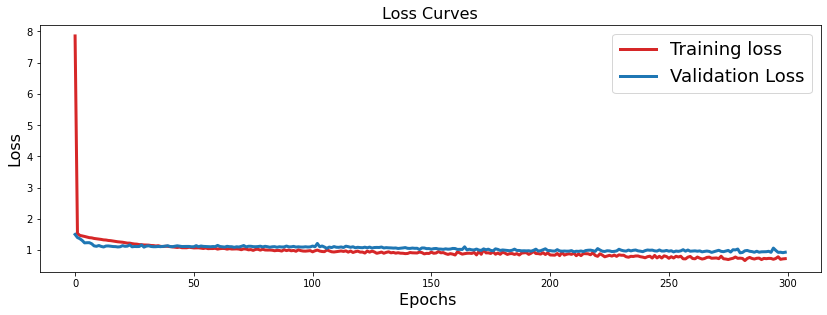

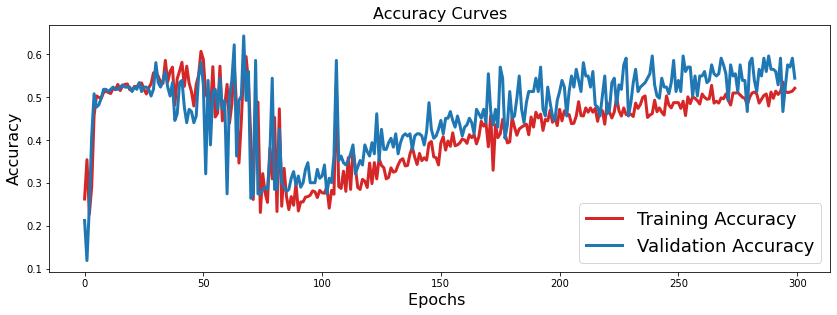

In [354]:
plotfn(history)

> **Evaluation:** Testing

In [355]:
evaluation_test(model, X_test, Y_test, results, index)

7/7 [==============================] - 0s 3ms/step - loss: 1.1034 - accuracy: 0.6528
Test accuracy: 0.6528497338294983
Test loss: 1.1034021377563477


### **Evaluation Metrics**

> F1 score

In [356]:
_,_ , _, val_f1 = predictfn(model, X_val, Y_val)

7/7 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

    extrahls       1.00      0.68      0.81        22
  extrastole       0.09      0.17      0.12         6
      murmur       0.51      0.70      0.59        40
      normal       0.85      0.76      0.80       125

    accuracy                           0.72       193
   macro avg       0.61      0.58      0.58       193
weighted avg       0.77      0.72      0.74       193



In [357]:
predictions,y_pred , y_true, test_f1 = predictfn(model,X_test,Y_test)

7/7 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

    extrahls       1.00      0.26      0.41        23
  extrastole       0.00      0.00      0.00         8
      murmur       0.54      0.78      0.64        41
      normal       0.77      0.73      0.75       121

    accuracy                           0.65       193
   macro avg       0.58      0.44      0.45       193
weighted avg       0.71      0.65      0.65       193



> Confusion Matrix

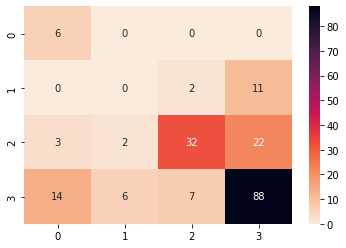

In [358]:
matrix = confusion_matrix(y_true ,y_pred)
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r')

***COMMENTS***
> This model is not good at classifying all classes as class 1 and 2 are almost always misclassified. Therefore, the earlier MLP version was better.

> ROC and AUC

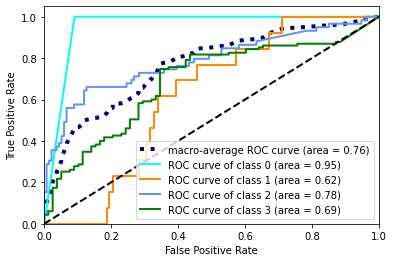

In [359]:
roc = plot_ROC(Y_test,predictions)

In [360]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred = to_categorical(y_pred)

7/7 [==============================] - 0s 2ms/step


In [361]:
results.loc[index,['Val f1','Test f1', 'Average ROC']] = [val_f1, test_f1, roc]
index = index + 1
results 

Architecture      LR    Dropout        Loss Fn Train Acc Train Loss  \
0       CNN 2D  0.0001        0.2  Cross-Entropy  0.972067   0.093446   
1       CNN 2D  0.0001  0.2 & 0.4  Cross-Entropy  0.911732   0.306483   
2       CNN 2D  0.0001        0.2        Poisson  0.994413     0.0239   
3       CNN 2D  0.0001        0.2  KL divergence  0.984358   0.079908   
4       CNN 2D   0.001        0.2  Cross-Entropy  0.994413   0.021668   
5       CNN 1D  0.0001        0.2  Cross-Entropy  0.832402   0.413392   
6     ANN: MLP  0.0001        0.1  Cross-Entropy  0.642463   0.827357   
7     ANN: MLP   0.001        0.1  Cross-Entropy  0.674632   1.059883   

    Val Acc  Val Loss  Test Acc Test Loss    Val f1   Test f1 Average ROC  
0  0.948187  0.211522  0.813471  0.574236  0.947918  0.809101    0.961442  
1  0.860104  0.358453  0.797927  0.506057   0.85249  0.788991    0.959572  
2  0.896373  0.336143  0.829016   0.66938  0.896635  0.826424     0.95547  
3  0.911917  0.285003  0.797927  0.508575  0.911012  0.799109    0.958595  
4  0.917098   0.27322  0.834197  0.566831   0.91787  0.837258    0.960526  
5  0.699482  1.062132   0.61658  1.164043  0.705761  0.607259    0.791756  
6  0.699482  0.728798  0.564767  0.986058  0.694605  0.550542    0.822062  
7  0.720207  1.000679   0.65285  1.103402   0.73748  0.652821    0.764952

#### Predicting a sample's label





In [365]:
model_name = "heartbeat_classifierMLP.h5"
model.save(model_name)

##### Predicting a **Murmur** sample

In [371]:
test.iloc[5]

filename    /content/set_b/murmur__281_1311165683454_D.wav
label                                               murmur
offset                                                   3
Name: 997, dtype: object

In [367]:
sample_predict(model_name,5)

1/1 [==============================] - 0s 140ms/step
Label Prediction Probabilities: [[7.3190015e-05 3.3656955e-01 3.3715203e-01 3.2620528e-01]]
----------------------------------------
Label:
Murmur heartbeat
confidence: 0.33715203


##### Predicting a **Normal** sample

In [369]:
test.iloc[10]

filename    /content/set_b/normal_noisynormal_141_13065201...
label                                                  normal
offset                                                      3
Name: 488, dtype: object

In [370]:
sample_predict(model_name,10)

1/1 [==============================] - 0s 127ms/step
Label Prediction Probabilities: [[3.0636352e-07 3.5694864e-01 2.7347854e-01 3.6957249e-01]]
----------------------------------------
Label:
Normal heartbeat
confidence: 0.3695725


##### Predicting an **Extrahls** sample

In [373]:
test.iloc[77]

filename    /content/set_a/extrahls__201101241433.wav
label                                        extrahls
offset                                              3
Name: 47, dtype: object

In [372]:
sample_predict(model_name,77)

1/1 [==============================] - 0s 97ms/step
Label Prediction Probabilities: [[0.5893133  0.11770125 0.19179145 0.10119393]]
----------------------------------------
Label:
Extrahls heartbeat
confidence: 0.5893133


## RNN Experiment: LSTM

In [394]:
model = Sequential()
model.add(LSTM(units=64, dropout=0.05, recurrent_dropout=0.20, return_sequences=True,input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(LSTM(units=32, dropout=0.05, recurrent_dropout=0.20, return_sequences=False))
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 40, 64)            49920     
                                                                 
 lstm_8 (LSTM)               (None, 32)                12416     
                                                                 
 dense_68 (Dense)            (None, 4)                 132       
                                                                 
Total params: 62,468
Trainable params: 62,468
Non-trainable params: 0
_________________________________________________________________


In [395]:
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
filepath="/content/weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(x_train, y_train, batch_size = 100, epochs=150, verbose=1, validation_data=(x_val, y_val), shuffle=True, callbacks = [checkpoint], class_weight=class_Weights)

Epoch 1/150
9/9 [==============================] - ETA: 0s - loss: 1.3680 - accuracy: 0.3553
Epoch 1: val_accuracy improved from -inf to 0.40415, saving model to /content/weights.best.hdf5
9/9 [==============================] - 8s 276ms/step - loss: 1.3680 - accuracy: 0.3553 - val_loss: 1.3119 - val_accuracy: 0.4041
Epoch 2/150
9/9 [==============================] - ETA: 0s - loss: 1.1558 - accuracy: 0.3296
Epoch 2: val_accuracy did not improve from 0.40415
9/9 [==============================] - 2s 177ms/step - loss: 1.1558 - accuracy: 0.3296 - val_loss: 1.2829 - val_accuracy: 0.3316
Epoch 3/150
9/9 [==============================] - ETA: 0s - loss: 0.9942 - accuracy: 0.3039
Epoch 3: val_accuracy did not improve from 0.40415
9/9 [==============================] - 2s 166ms/step - loss: 0.9942 - accuracy: 0.3039 - val_loss: 1.2306 - val_accuracy: 0.3057
Epoch 4/150
9/9 [==============================] - ETA: 0s - loss: 0.8867 - accuracy: 0.3587
Epoch 4: val_accuracy did not improve from 

In [438]:
results.loc[index,['Architecture','Dropout','Loss Fn', 'LR']] = ['RNN: LSTM','0.05 & 0.2', 'Cross-Entropy',0.0001] 

> **Evaluation:** Training and Validation



In [439]:
evaluation_train_val(model, x_train, y_train, x_val, y_val, results, index)

Training Accuracy:  1.0
Training Loss:  0.0004262325819581747
Validation Accuracy:  0.6321243643760681
Validation Loss:  2.286165952682495


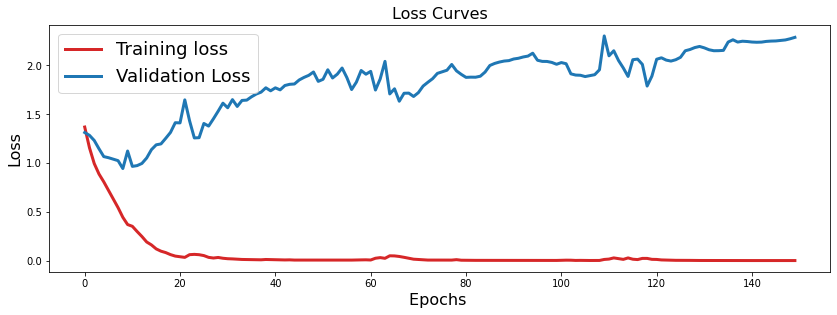

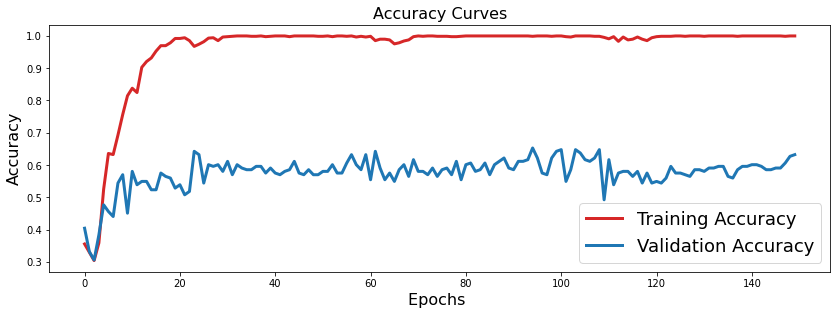

In [440]:
plotfn(history)

> **Evaluation:** Testing

In [441]:
evaluation_test(model, x_test, y_test, results, index)

7/7 [==============================] - 0s 19ms/step - loss: 2.3156 - accuracy: 0.5959
Test accuracy: 0.5958549380302429
Test loss: 2.315556287765503


***COMMENTS***
> It is quite obvious that this model is overfitting, maybe our RNN model needs some adjustments. But we added it just to see various architectures and their accuracies.

### **Evaluation Metrics**

> F1 score

In [442]:
_,_ , _, val_f1 = predictfn(model, x_val, y_val)

7/7 [==============================] - 0s 20ms/step
              precision    recall  f1-score   support

    extrahls       0.53      1.00      0.70         8
  extrastole       0.00      0.00      0.00         6
      murmur       0.33      0.58      0.42        31
      normal       0.86      0.65      0.74       148

    accuracy                           0.63       193
   macro avg       0.43      0.56      0.46       193
weighted avg       0.73      0.63      0.66       193



In [443]:
predictions,y_pred , y_true, test_f1 = predictfn(model,x_test,y_test)

7/7 [==============================] - 0s 16ms/step
              precision    recall  f1-score   support

    extrahls       0.83      0.45      0.59        11
  extrastole       0.15      0.25      0.19         8
      murmur       0.34      0.45      0.39        44
      normal       0.77      0.68      0.72       130

    accuracy                           0.60       193
   macro avg       0.52      0.46      0.47       193
weighted avg       0.65      0.60      0.61       193



> Confusion Matrix

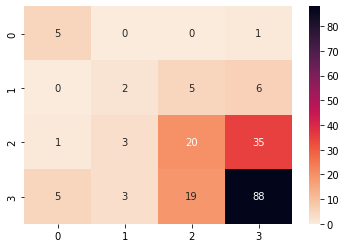

In [444]:
matrix = confusion_matrix(y_true ,y_pred)
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r')

> ROC and AUC

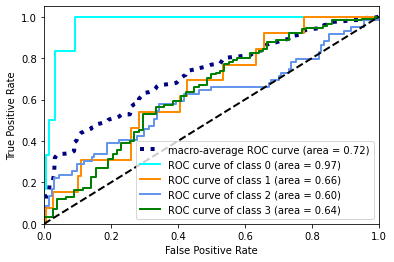

In [445]:
roc = plot_ROC(Y_test,predictions)

In [446]:
results.loc[index,['Val f1','Test f1', 'Average ROC']] = [val_f1, test_f1, roc]
index = index + 1
results 

Architecture      LR     Dropout        Loss Fn Train Acc Train Loss  \
0       CNN 2D  0.0001         0.2  Cross-Entropy  0.972067   0.093446   
1       CNN 2D  0.0001   0.2 & 0.4  Cross-Entropy  0.911732   0.306483   
2       CNN 2D  0.0001         0.2        Poisson  0.994413     0.0239   
3       CNN 2D  0.0001         0.2  KL divergence  0.984358   0.079908   
4       CNN 2D   0.001         0.2  Cross-Entropy  0.994413   0.021668   
5       CNN 1D  0.0001         0.2  Cross-Entropy  0.832402   0.413392   
6     ANN: MLP  0.0001         0.1  Cross-Entropy  0.642463   0.827357   
7     ANN: MLP   0.001         0.1  Cross-Entropy  0.674632   1.059883   
8    RNN: LSTM  0.0001  0.05 & 0.2  Cross-Entropy       1.0   0.000426   

    Val Acc  Val Loss  Test Acc Test Loss    Val f1   Test f1 Average ROC  
0  0.948187  0.211522  0.813471  0.574236  0.947918  0.809101    0.961442  
1  0.860104  0.358453  0.797927  0.506057   0.85249  0.788991    0.959572  
2  0.896373  0.336143  0.829016   0.66938  0.896635  0.826424     0.95547  
3  0.911917  0.285003  0.797927  0.508575  0.911012  0.799109    0.958595  
4  0.917098   0.27322  0.834197  0.566831   0.91787  0.837258    0.960526  
5  0.699482  1.062132   0.61658  1.164043  0.705761  0.607259    0.791756  
6  0.699482  0.728798  0.564767  0.986058  0.694605  0.550542    0.822062  
7  0.720207  1.000679   0.65285  1.103402   0.73748  0.652821    0.764952  
8  0.632124  2.286166  0.595855  2.315556  0.662354  0.613832    0.721467

#### Predicting a sample's label





In [396]:
model_name = "heartbeat_classifierLSTM.h5"
model.save(model_name)

##### Predicting a **Murmur** sample

In [414]:
test.iloc[55]

filename    /content/set_b/murmur__122_1306325762831_D.wav
label                                               murmur
offset                                                   7
Name: 691, dtype: object

In [415]:
sample_predict(model_name,55)

1/1 [==============================] - 1s 987ms/step
Label Prediction Probabilities: [[7.0116170e-05 1.2926321e-03 9.9701762e-01 1.6196346e-03]]
----------------------------------------
Label:
Murmur heartbeat
confidence: 0.9970176


##### Predicting a **Normal** sample

In [ ]:
test.iloc[50]

filename    /content/set_a/normal__201101151127.wav
label                                        normal
offset                                            3
Name: 165, dtype: object

In [398]:
sample_predict(model_name,50)

1/1 [==============================] - 1s 648ms/step
Label Prediction Probabilities: [[0.00100539 0.04062511 0.11192766 0.84644186]]
----------------------------------------
Label:
Normal heartbeat
confidence: 0.84644186


##### Predicting an **Extrahls** sample

In [ ]:
test.iloc[77]

filename    /content/set_a/extrahls__201101241433.wav
label                                        extrahls
offset                                              3
Name: 47, dtype: object

In [399]:
sample_predict(model_name,77)

1/1 [==============================] - 1s 658ms/step
Label Prediction Probabilities: [[0.5306326  0.00132648 0.05272905 0.41531187]]
----------------------------------------
Label:
Extrahls heartbeat
confidence: 0.5306326


##### Predicting a **Extrasystole** sample

In [ ]:
test.iloc[16] 

filename    /content/set_b/extrastole__140_1306519735121_D...
label                                              extrastole
offset                                                      1
Name: 245, dtype: object

In [402]:
sample_predict(model_name,96)

1/1 [==============================] - 1s 1s/step
Label Prediction Probabilities: [[0.00088884 0.75414175 0.00135688 0.2436126 ]]
----------------------------------------
Label:
Extrasystole heartbeat
confidence: 0.75414175


# Final Tabulated Results

In [448]:
results

Architecture      LR     Dropout        Loss Fn Train Acc Train Loss  \
0       CNN 2D  0.0001         0.2  Cross-Entropy  0.972067   0.093446   
1       CNN 2D  0.0001   0.2 & 0.4  Cross-Entropy  0.911732   0.306483   
2       CNN 2D  0.0001         0.2        Poisson  0.994413     0.0239   
3       CNN 2D  0.0001         0.2  KL divergence  0.984358   0.079908   
4       CNN 2D   0.001         0.2  Cross-Entropy  0.994413   0.021668   
5       CNN 1D  0.0001         0.2  Cross-Entropy  0.832402   0.413392   
6     ANN: MLP  0.0001         0.1  Cross-Entropy  0.642463   0.827357   
7     ANN: MLP   0.001         0.1  Cross-Entropy  0.674632   1.059883   
8    RNN: LSTM  0.0001  0.05 & 0.2  Cross-Entropy       1.0   0.000426   

    Val Acc  Val Loss  Test Acc Test Loss    Val f1   Test f1 Average ROC  
0  0.948187  0.211522  0.813471  0.574236  0.947918  0.809101    0.961442  
1  0.860104  0.358453  0.797927  0.506057   0.85249  0.788991    0.959572  
2  0.896373  0.336143  0.829016   0.66938  0.896635  0.826424     0.95547  
3  0.911917  0.285003  0.797927  0.508575  0.911012  0.799109    0.958595  
4  0.917098   0.27322  0.834197  0.566831   0.91787  0.837258    0.960526  
5  0.699482  1.062132   0.61658  1.164043  0.705761  0.607259    0.791756  
6  0.699482  0.728798  0.564767  0.986058  0.694605  0.550542    0.822062  
7  0.720207  1.000679   0.65285  1.103402   0.73748  0.652821    0.764952  
8  0.632124  2.286166  0.595855  2.315556  0.662354  0.613832    0.721467